In [1]:
import seaborn as sns
import pandas as pd
import re
import matplotlib as mpl
from matplotlib import rc
import missingno as msno
import warnings
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')

# matplotlib 한글 사용을 위한 코드
rc('font', family='AppleGothic')

In [2]:
final_df = pd.read_csv(
    '../../final_df_14/final_df_14.csv', encoding="cp949").drop(columns='Unnamed: 0')
X_train = pd.read_csv(
    '../../final_df_14/X_train_14.csv').drop(columns='Unnamed: 0')
y_train = pd.read_csv(
    '../../final_df_14/y_train_14.csv').drop(columns='Unnamed: 0')
X_test = pd.read_csv(
    '../../final_df_14/X_test_14.csv').drop(columns='Unnamed: 0')
y_test = pd.read_csv(
    '../../final_df_14/y_test_14.csv').drop(columns='Unnamed: 0')

In [3]:
# X_train.drop(columns=['aud_nationwide', 'log_aud'], inplace=True)
# X_test.drop(columns=['aud_nationwide', 'log_aud'], inplace=True)

In [4]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   title                 925 non-null    object 
 1   director              925 non-null    object 
 2   distributor           925 non-null    object 
 3   distributor_group     925 non-null    object 
 4   release_date          925 non-null    int64  
 5   release_season        925 non-null    object 
 6   release               925 non-null    object 
 7   form                  925 non-null    object 
 8   nation                925 non-null    object 
 9   screen                925 non-null    int64  
 10  rev_nationwide        925 non-null    float64
 11  aud_nationwide        925 non-null    int64  
 12  rev_seoul             925 non-null    int64  
 13  rev_seoul.1           925 non-null    int64  
 14  genre                 925 non-null    object 
 15  rate                  9

In [5]:
len(X_train), len(X_test), len(y_train), len(y_test),

(740, 185, 740, 185)

In [6]:
df = pd.concat([X_train, y_train], axis=1)

In [7]:
len(df.columns)

35

In [8]:
df = df.drop(columns=['distributor_group', 'release', 'form',
                      'rev_nationwide', 'rev_seoul', 'rev_seoul.1', 'director_count'])

In [9]:
len(df.columns)

28

In [10]:
df.columns

Index(['title', 'director', 'distributor', 'release_date', 'release_season',
       'nation', 'screen', 'genre', 'rate', 'type', 'expert_rating',
       'starring_actors', 'running_times', 'audience_rating',
       'rating_audiences', 'realease_year', 'director_power', 'sequel',
       'original', 'actor_power', 'director_movie_count', 'actor_movie_count',
       'before_news', 'after_news', 'holiday', 'dist_cat', 'aud_nationwide',
       'log_aud'],
      dtype='object')

# 흐름
- screen, expert_rating, audience_rating, running_times, sequel, original, nation,  genre, rate, dist_cat : 10개 컬럼 사용
- actor_power, director_power 추가
- before_news, after_news 추가
- rating_audiences 추가
- holiday 추가
- 종속변수에 로그취하기, news 피쳐에 로그취하기
- 각 독립변수의 잔차 비선형성 제거
- 아웃라이어 제거
- VIF, ANOVA 
- Ridge, Lasso 적용


# model1
- 참고 논문들에서 사용한 독립변수들 사용
- 10개 피쳐들 단순 적용
    - screen, expert_rating, audience_rating, running_times, sequel, original, nation,  genre, rate, dist_cat


In [11]:
test_rsquare_dict = {}
kfold_dict_learn = {}
kfold_dict = {}
kfold_dict_avr = []
RMSE_dict = {}
result_rsquare = {}
result_adj_rsquare = {}
kfold_df = pd.DataFrame()

In [12]:
df1 = df.copy()

In [13]:
# 10개의 독립변수 사용

feature_names = ['screen', 'expert_rating', 'audience_rating', 'running_times']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat',
                                                                        'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model1 = sm.OLS.from_formula(
    "aud_nationwide ~" + "+".join(feature_names), data=df1)
result1 = model1.fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:         aud_nationwide   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     45.92
Date:                Thu, 16 Apr 2020   Prob (F-statistic):          6.80e-142
Time:                        19:04:49   Log-Likelihood:                -11405.
No. Observations:                 740   AIC:                         2.287e+04
Df Residuals:                     710   BIC:                         2.301e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               7.57

In [14]:
# kfold 1

from sklearn.model_selection import KFold

kfold_dict_learn['1'] = []
kfold_dict['1'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df1)):
    df_train = df1.iloc[idx_train]
    df_test = df1.iloc[idx_test]

    model = sm.OLS.from_formula(
        "aud_nationwide ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'dist_cat',
                                   'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['aud_nationwide'] - pred) ** 2).sum()
    tss = ((df_test['aud_nationwide'] -
            df_test['aud_nationwide'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict_learn['1'].append(result.rsquared)
    kfold_dict['1'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['1'])/10)

학습 R2 = 0.65211451, 검증 R2 = 0.64305748
학습 R2 = 0.64854685, 검증 R2 = 0.68184139
학습 R2 = 0.64333485, 검증 R2 = 0.67402159
학습 R2 = 0.65503339, 검증 R2 = 0.60839195
학습 R2 = 0.65137804, 검증 R2 = 0.63919861
학습 R2 = 0.64319284, 검증 R2 = 0.72309674
학습 R2 = 0.65757770, 검증 R2 = 0.58053591
학습 R2 = 0.68605278, 검증 R2 = 0.36103947
학습 R2 = 0.65555049, 검증 R2 = 0.57760004
학습 R2 = 0.64081401, 검증 R2 = 0.69909107


In [15]:
# model1의 테스트 R

pred = result1.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'dist_cat',
                               'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['aud_nationwide'] - pred) ** 2).sum()
tss = ((y_test['aud_nationwide'] - y_test['aud_nationwide'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.6063840307534749

In [16]:
pred = result1.predict(X_test)
print('Mean_Squared_Error = ', mean_squared_error(
    pred, y_test['aud_nationwide']))
print('RMSE = ', mean_squared_error(pred, y_test['aud_nationwide'])**0.5)
RMSE_dict['1'] = mean_squared_error(pred, y_test['aud_nationwide'])**0.5

Mean_Squared_Error =  1480648594999.2756
RMSE =  1216819.0477631732


In [17]:
result_rsquare['result1_rsquared'] = result1.rsquared
result_adj_rsquare['result1_adj_rsquared'] = result1.rsquared_adj

In [18]:
test_rsquare_dict['1'] = rsquared

# model2
- actor_power, director_power 추가

In [19]:
df2 = df1.copy()

In [20]:
# 12개의 독립변수 사용

feature_names = ['screen', 'expert_rating', 'audience_rating',
                 'running_times', 'actor_power', 'director_power']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat',
                                                                        'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model2 = sm.OLS.from_formula(
    "aud_nationwide ~" + "+".join(feature_names), data=df2)
result2 = model2.fit()
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:         aud_nationwide   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     45.53
Date:                Thu, 16 Apr 2020   Prob (F-statistic):          2.76e-146
Time:                        19:04:54   Log-Likelihood:                -11390.
No. Observations:                 740   AIC:                         2.284e+04
Df Residuals:                     708   BIC:                         2.299e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               7.60

In [21]:
# kfold 2

from sklearn.model_selection import KFold

kfold_dict_learn['2'] = []
kfold_dict['2'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df2)):
    df_train = df2.iloc[idx_train]
    df_test = df2.iloc[idx_test]

    model = sm.OLS.from_formula(
        "aud_nationwide ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'dist_cat',
                                   'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['aud_nationwide'] - pred) ** 2).sum()
    tss = ((df_test['aud_nationwide'] -
            df_test['aud_nationwide'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict_learn['2'].append(result.rsquared)
    kfold_dict['2'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['2'])/10)

학습 R2 = 0.66498141, 검증 R2 = 0.66241464
학습 R2 = 0.66401365, 검증 R2 = 0.67229819
학습 R2 = 0.65411530, 검증 R2 = 0.70154754
학습 R2 = 0.66651418, 검증 R2 = 0.65086356
학습 R2 = 0.66730639, 검증 R2 = 0.60629479
학습 R2 = 0.65840796, 검증 R2 = 0.71739871
학습 R2 = 0.67264766, 검증 R2 = 0.57948672
학습 R2 = 0.69427664, 검증 R2 = 0.41135605
학습 R2 = 0.66997354, 검증 R2 = 0.58403934
학습 R2 = 0.66030769, 검증 R2 = 0.67135977


In [22]:
# model2의 테스트 R

pred = result2.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'dist_cat',
                               'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['aud_nationwide'] - pred) ** 2).sum()
tss = ((y_test['aud_nationwide'] - y_test['aud_nationwide'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.6243355959961607

In [23]:
test_rsquare_dict['2'] = rsquared

In [24]:
pred = result2.predict(X_test)
print('Mean_Squared_Error = ', mean_squared_error(
    pred, y_test['aud_nationwide']))
print('RMSE = ', mean_squared_error(pred, y_test['aud_nationwide'])**0.5)
RMSE_dict['2'] = mean_squared_error(pred, y_test['aud_nationwide'])**0.5

Mean_Squared_Error =  1413120948939.841
RMSE =  1188747.638878766


In [25]:
result_rsquare['result2_rsquared'] = result2.rsquared
result_adj_rsquare['result2_adj_rsquared'] = result2.rsquared_adj

# model3
- before_news, after_news 추가

In [26]:
df3 = df2.copy()

In [27]:
# 14개의 독립변수 사용

feature_names = ['screen', 'expert_rating', 'audience_rating', 'running_times',
                 'actor_power', 'director_power', 'before_news', 'after_news']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat',
                                                                        'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model3 = sm.OLS.from_formula(
    "aud_nationwide ~" + "+".join(feature_names), data=df3)
result3 = model3.fit()
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:         aud_nationwide   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     47.53
Date:                Thu, 16 Apr 2020   Prob (F-statistic):          1.20e-155
Time:                        19:05:01   Log-Likelihood:                -11363.
No. Observations:                 740   AIC:                         2.279e+04
Df Residuals:                     706   BIC:                         2.295e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               8.28

In [28]:
# kfold 3

from sklearn.model_selection import KFold

kfold_dict_learn['3'] = []
kfold_dict['3'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df3)):
    df_train = df3.iloc[idx_train]
    df_test = df3.iloc[idx_test]

    model = sm.OLS.from_formula(
        "aud_nationwide ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news', 'after_news', 'dist_cat',
                                   'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['aud_nationwide'] - pred) ** 2).sum()
    tss = ((df_test['aud_nationwide'] -
            df_test['aud_nationwide'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict_learn['3'].append(result.rsquared)
    kfold_dict['3'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['3'])/10)

학습 R2 = 0.68853920, 검증 R2 = 0.68673027
학습 R2 = 0.68284680, 검증 R2 = 0.76228227
학습 R2 = 0.68020463, 검증 R2 = 0.71321405
학습 R2 = 0.69279813, 검증 R2 = 0.64056900
학습 R2 = 0.69104915, 검증 R2 = 0.62879596
학습 R2 = 0.68664015, 검증 R2 = 0.68585173
학습 R2 = 0.68940175, 검증 R2 = 0.66769567
학습 R2 = 0.72118241, 검증 R2 = 0.40690405
학습 R2 = 0.69552578, 검증 R2 = 0.57533130
학습 R2 = 0.68324363, 검증 R2 = 0.69996448


In [29]:
# model3의 테스트 R

pred = result3.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news', 'after_news', 'dist_cat',
                               'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['aud_nationwide'] - pred) ** 2).sum()
tss = ((y_test['aud_nationwide'] - y_test['aud_nationwide'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.6445087799148355

In [30]:
test_rsquare_dict['3'] = rsquared

In [31]:
pred = result3.predict(X_test)
print('Mean_Squared_Error = ', mean_squared_error(
    pred, y_test['aud_nationwide']))
print('RMSE = ', mean_squared_error(pred, y_test['aud_nationwide'])**0.5)
RMSE_dict['3'] = mean_squared_error(pred, y_test['aud_nationwide'])**0.5

Mean_Squared_Error =  1337236333579.7866
RMSE =  1156389.3520695297


In [32]:
result_rsquare['result3_rsquared'] = result3.rsquared
result_adj_rsquare['result3_adj_rsquared'] = result3.rsquared_adj

# model4
- rating_audiences 추가 

In [33]:
df4 = df3.copy()

In [34]:
# 15개의 독립변수 사용

feature_names = ['screen', 'expert_rating', 'audience_rating', 'running_times',
                 'actor_power', 'director_power', 'before_news', 'after_news', 'rating_audiences']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat',
                                                                        'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model4 = sm.OLS.from_formula(
    "aud_nationwide ~" + "+".join(feature_names), data=df4)
result4 = model4.fit()
print(result4.summary())

                            OLS Regression Results                            
Dep. Variable:         aud_nationwide   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     59.93
Date:                Thu, 16 Apr 2020   Prob (F-statistic):          3.69e-183
Time:                        19:05:12   Log-Likelihood:                -11293.
No. Observations:                 740   AIC:                         2.266e+04
Df Residuals:                     705   BIC:                         2.282e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                9

In [35]:
# kfold 4

from sklearn.model_selection import KFold

kfold_dict_learn['4'] = []
kfold_dict['4'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df4)):
    df_train = df4.iloc[idx_train]
    df_test = df4.iloc[idx_test]

    model = sm.OLS.from_formula(
        "aud_nationwide ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news', 'after_news', 'rating_audiences', 'dist_cat',
                                   'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['aud_nationwide'] - pred) ** 2).sum()
    tss = ((df_test['aud_nationwide'] -
            df_test['aud_nationwide'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict_learn['4'].append(result.rsquared)
    kfold_dict['4'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['4'])/10)

학습 R2 = 0.74325552, 검증 R2 = 0.73025309
학습 R2 = 0.73678227, 검증 R2 = 0.81312361
학습 R2 = 0.75912834, 검증 R2 = 0.49906999
학습 R2 = 0.74333416, 검증 R2 = 0.73092590
학습 R2 = 0.74130819, 검증 R2 = 0.75381165
학습 R2 = 0.73567343, 검증 R2 = 0.79679714
학습 R2 = 0.73169839, 검증 R2 = 0.84482117
학습 R2 = 0.77969845, 검증 R2 = 0.42026655
학습 R2 = 0.74538901, 검증 R2 = 0.68728025
학습 R2 = 0.73899896, 검증 R2 = 0.74426151


In [36]:
# model4의 테스트 R

pred = result4.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news', 'after_news', 'rating_audiences', 'dist_cat',
                               'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['aud_nationwide'] - pred) ** 2).sum()
tss = ((y_test['aud_nationwide'] - y_test['aud_nationwide'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.7048007034475638

In [37]:
test_rsquare_dict['4'] = rsquared

In [38]:
pred = result4.predict(X_test)
print('Mean_Squared_Error = ', mean_squared_error(
    pred, y_test['aud_nationwide']))
print('RMSE = ', mean_squared_error(pred, y_test['aud_nationwide'])**0.5)
RMSE_dict['4'] = mean_squared_error(pred, y_test['aud_nationwide'])**0.5

Mean_Squared_Error =  1110438746989.4246
RMSE =  1053773.5748202384


In [39]:
result_rsquare['result4_rsquared'] = result4.rsquared
result_adj_rsquare['result4_adj_rsquared'] = result4.rsquared_adj

# model5
- holiday 추가

In [40]:
df5 = df4.copy()

In [41]:
# 16개의 독립변수 사용

feature_names = ['screen', 'expert_rating', 'audience_rating', 'running_times',
                 'actor_power', 'director_power', 'before_news', 'after_news', 'rating_audiences']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat', 'C(holiday)',
                                                                        'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model5 = sm.OLS.from_formula(
    "aud_nationwide ~" + "+".join(feature_names), data=df5)
result5 = model5.fit()
print(result5.summary())

                            OLS Regression Results                            
Dep. Variable:         aud_nationwide   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     58.48
Date:                Thu, 16 Apr 2020   Prob (F-statistic):          6.53e-183
Time:                        19:05:23   Log-Likelihood:                -11292.
No. Observations:                 740   AIC:                         2.266e+04
Df Residuals:                     704   BIC:                         2.282e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [42]:
# kfold 5

from sklearn.model_selection import KFold

kfold_dict_learn['5'] = []
kfold_dict['5'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df5)):
    df_train = df5.iloc[idx_train]
    df_test = df5.iloc[idx_test]

    model = sm.OLS.from_formula(
        "aud_nationwide ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news', 'after_news', 'rating_audiences', 'holiday', 'dist_cat',
                                   'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['aud_nationwide'] - pred) ** 2).sum()
    tss = ((df_test['aud_nationwide'] -
            df_test['aud_nationwide'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict_learn['5'].append(result.rsquared)
    kfold_dict['5'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['5'])/10)

학습 R2 = 0.74416492, 검증 R2 = 0.73278592
학습 R2 = 0.73818246, 검증 R2 = 0.80929549
학습 R2 = 0.76002685, 검증 R2 = 0.50139675
학습 R2 = 0.74447553, 검증 R2 = 0.73195975
학습 R2 = 0.74316616, 검증 R2 = 0.73400369
학습 R2 = 0.73745404, 검증 R2 = 0.78923608
학습 R2 = 0.73249659, 검증 R2 = 0.84936533
학습 R2 = 0.78050370, 검증 R2 = 0.42367878
학습 R2 = 0.74670011, 검증 R2 = 0.68496689
학습 R2 = 0.73951747, 검증 R2 = 0.74795337


In [43]:
# model5의 테스트 R

pred = result5.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news', 'after_news', 'rating_audiences', 'holiday', 'dist_cat',
                               'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['aud_nationwide'] - pred) ** 2).sum()
tss = ((y_test['aud_nationwide'] - y_test['aud_nationwide'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.6990985325678982

In [44]:
test_rsquare_dict['5'] = rsquared

In [45]:
pred = result5.predict(X_test)
print('Mean_Squared_Error = ', mean_squared_error(
    pred, y_test['aud_nationwide']))
print('RMSE = ', mean_squared_error(pred, y_test['aud_nationwide'])**0.5)
RMSE_dict['5'] = mean_squared_error(pred, y_test['aud_nationwide'])**0.5

Mean_Squared_Error =  1131888362759.8018
RMSE =  1063902.4216345227


In [46]:
result_rsquare['result5_rsquared'] = result5.rsquared
result_adj_rsquare['result5_adj_rsquared'] = result5.rsquared_adj

# model6
- 종속변수에 log

In [47]:
df6 = df5.copy()

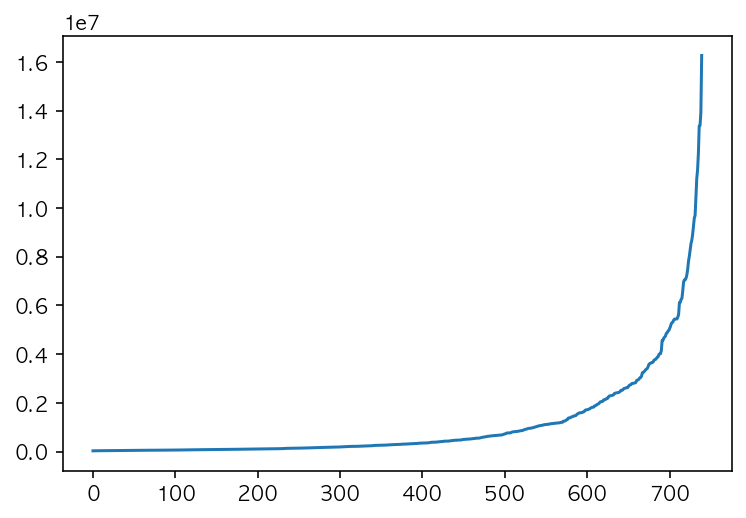

In [48]:
plt.plot(df6['aud_nationwide'].sort_values().reset_index(drop=True));

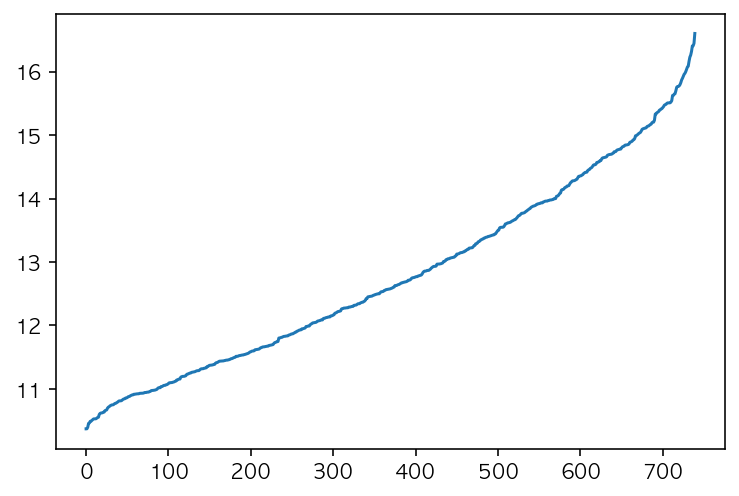

In [49]:
plt.plot(np.log(df6['aud_nationwide'].sort_values().reset_index(drop=True)));

In [50]:
# 16개의 독립변수 사용

feature_names = ['screen', 'expert_rating', 'audience_rating', 'running_times',
                 'actor_power', 'director_power', 'before_news', 'after_news', 'rating_audiences']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat', 'C(holiday)',
                                                                        'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model6 = sm.OLS.from_formula(
    "log_aud ~" + "+".join(feature_names), data=df6)
result6 = model6.fit()
print(result6.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     73.10
Date:                Thu, 16 Apr 2020   Prob (F-statistic):          1.25e-208
Time:                        19:05:45   Log-Likelihood:                -780.17
No. Observations:                 740   AIC:                             1632.
Df Residuals:                     704   BIC:                             1798.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [51]:
# kfold 6

from sklearn.model_selection import KFold

kfold_dict_learn['6'] = []
kfold_dict['6'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df6)):
    df_train = df6.iloc[idx_train]
    df_test = df6.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news', 'after_news', 'rating_audiences', 'holiday', 'dist_cat',
                                   'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict_learn['6'].append(result.rsquared)
    kfold_dict['6'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['6'])/10)

학습 R2 = 0.78204344, 검증 R2 = 0.79079385
학습 R2 = 0.78587245, 검증 R2 = 0.74442310
학습 R2 = 0.78089355, 검증 R2 = 0.69765359
학습 R2 = 0.79094868, 검증 R2 = 0.71034140
학습 R2 = 0.78322373, 검증 R2 = 0.78212960
학습 R2 = 0.78699304, 검증 R2 = 0.73778184
학습 R2 = 0.78793671, 검증 R2 = 0.72369768
학습 R2 = 0.78691007, 검증 R2 = 0.74555826
학습 R2 = 0.78383108, 검증 R2 = 0.77178975
학습 R2 = 0.78948926, 검증 R2 = 0.72675976


In [52]:
# model6의 테스트 R

pred = result6.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news', 'after_news', 'rating_audiences', 'holiday', 'dist_cat',
                               'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['log_aud'] - pred) ** 2).sum()
tss = ((y_test['log_aud'] - y_test['log_aud'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.7439545187829599

In [53]:
test_rsquare_dict['6'] = rsquared

In [54]:
pred = result6.predict(X_test)
print('Mean_Squared_Error = ', mean_squared_error(
    pred, y_test['aud_nationwide']))
print('RMSE = ', mean_squared_error(pred, y_test['aud_nationwide'])**0.5)
RMSE_dict['6'] = mean_squared_error(pred, y_test['aud_nationwide'])**0.5

Mean_Squared_Error =  4822243532563.353
RMSE =  2195960.731106855


In [55]:
result_rsquare['result6_rsquared'] = result6.rsquared
result_adj_rsquare['result6_adj_rsquared'] = result6.rsquared_adj

# model7
- 독립변수 잔차의 비선형성 제거
    - screen : **(4/7)
    - rating_audiences : np.log
    - news 피쳐 처리 : np.log

In [56]:
df7 = df6.copy()

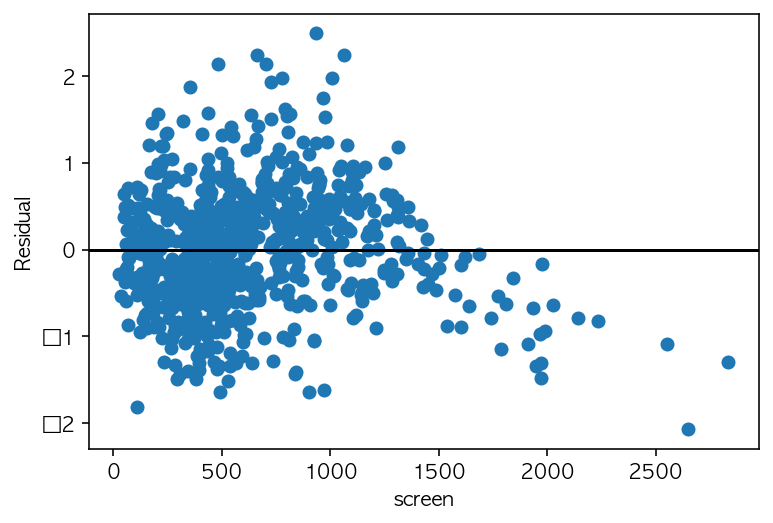

In [57]:
plt.plot(df7['screen'], result6.resid, 'o')
plt.axhline(y=0, c='k')
plt.xlabel("screen")
plt.ylabel("Residual")
plt.show()

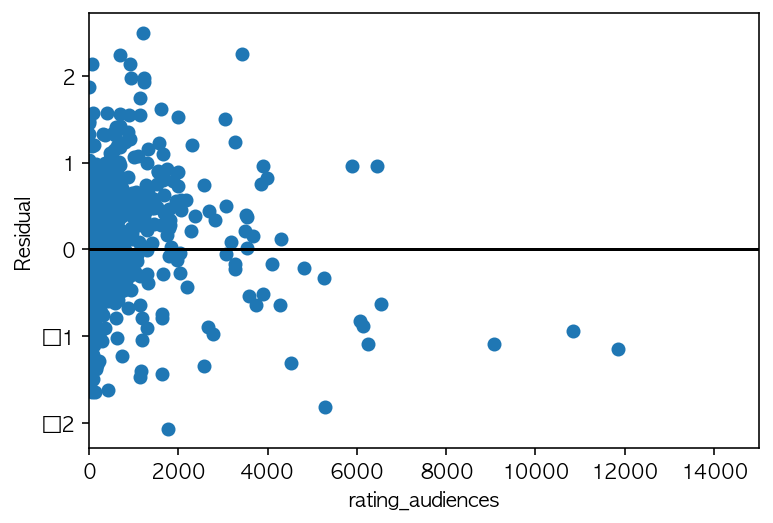

In [58]:
plt.plot(df7['rating_audiences'], result6.resid, 'o')
plt.axhline(y=0, c='k')
plt.xlabel("rating_audiences")
plt.ylabel("Residual")
plt.xlim(0, 15000)
plt.show()

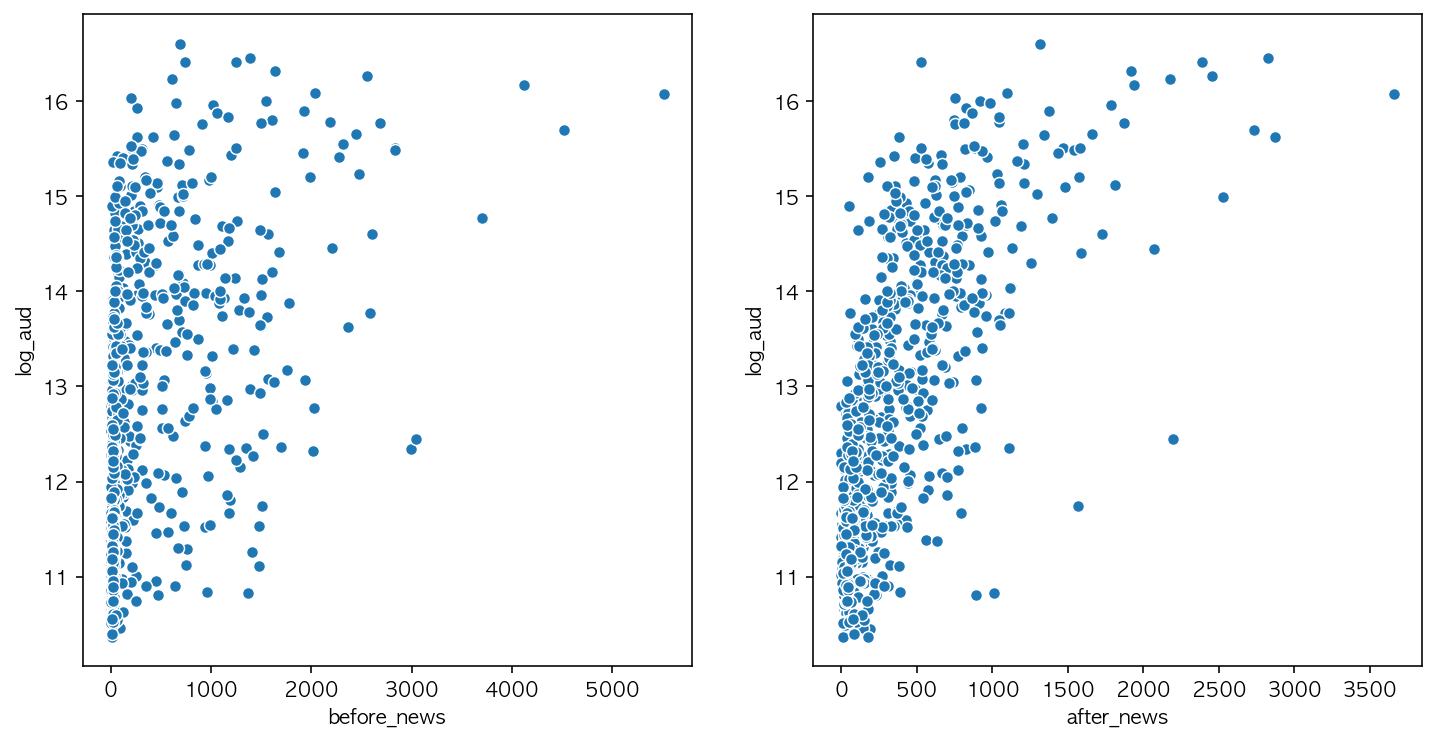

In [59]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.scatterplot(x="before_news", y="log_aud", data=df7)
plt.subplot(122)
sns.scatterplot(x="after_news", y="log_aud", data=df7)
plt.show()

In [60]:
df7['before_news_0to1'] = df7['before_news'].apply(
    lambda news: 1 if news == 0 else news)
df7['after_news_0to1'] = df7['after_news'].apply(
    lambda news: 1 if news == 0 else news)
df7['log_before_news'] = df7['before_news_0to1'].apply(
    lambda news: np.log(news))
df7['log_after_news'] = df7['after_news_0to1'].apply(
    lambda news: np.log(news))

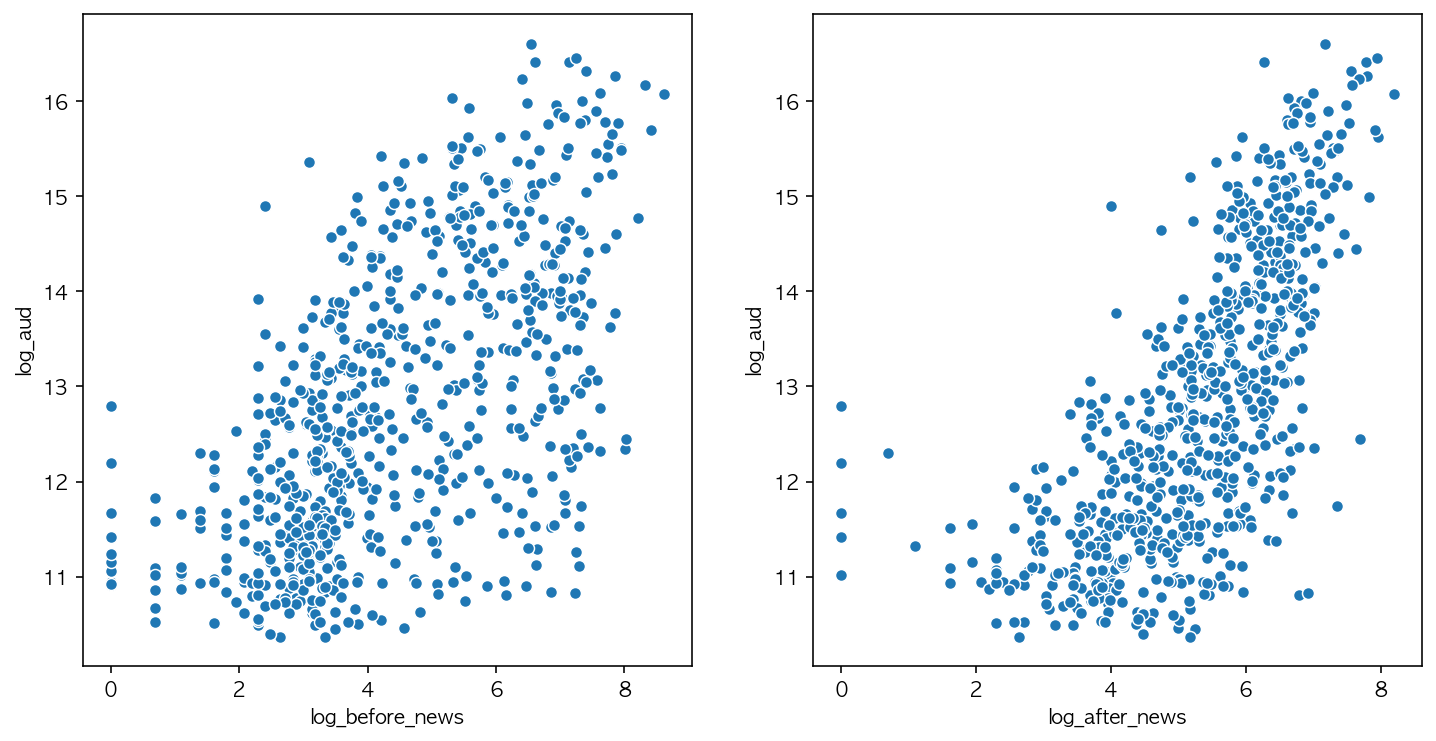

In [61]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.scatterplot(x="log_before_news", y="log_aud", data=df7)
plt.subplot(122)
sns.scatterplot(x="log_after_news", y="log_aud", data=df7)
plt.show()

In [62]:
df7['rating_audiences_0to1'] = df7['rating_audiences'].apply(lambda rate: 1 if rate == 0 else rate)

In [63]:
# 16개의 독립변수 사용

feature_names = ['screen**(4/7)', 'expert_rating', 'audience_rating', 'running_times',
                 'actor_power', 'director_power', 'np.log(before_news_0to1)', 'np.log(after_news_0to1)', 'np.log(rating_audiences_0to1)']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat', 'C(holiday)',
                                                                        'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model7 = sm.OLS.from_formula(
    "log_aud ~" + "+".join(feature_names), data=df7)
result7 = model7.fit()
print(result7.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     86.80
Date:                Thu, 16 Apr 2020   Prob (F-statistic):          2.43e-229
Time:                        19:06:13   Log-Likelihood:                -729.44
No. Observations:                 740   AIC:                             1531.
Df Residuals:                     704   BIC:                             1697.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [64]:
# kfold 7

from sklearn.model_selection import KFold

kfold_dict_learn['7'] = []
kfold_dict['7'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df7)):
    df_train = df7.iloc[idx_train]
    df_test = df7.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news_0to1', 'after_news_0to1', 'rating_audiences_0to1', 'holiday', 'dist_cat',
                                   'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict_learn['7'].append(result.rsquared)
    kfold_dict['7'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['7'])/10)

학습 R2 = 0.81006082, 검증 R2 = 0.81794888
학습 R2 = 0.81122614, 검증 R2 = 0.79691954
학습 R2 = 0.80660139, 검증 R2 = 0.83347783
학습 R2 = 0.81580761, 검증 R2 = 0.76859018
학습 R2 = 0.81386434, 검증 R2 = 0.77889368
학습 R2 = 0.81662427, 검증 R2 = 0.73985761
학습 R2 = 0.81696328, 검증 R2 = 0.73425426
학습 R2 = 0.81241887, 검증 R2 = 0.79393083
학습 R2 = 0.81080544, 검증 R2 = 0.80862510
학습 R2 = 0.81642726, 검증 R2 = 0.76344091


In [65]:
X_test['before_news_0to1'] = X_test['before_news'].apply(
    lambda news: 1 if news == 0 else news)
X_test['after_news_0to1'] = X_test['after_news'].apply(
    lambda news: 1 if news == 0 else news)

In [66]:
X_test['rating_audiences_0to1'] = X_test['rating_audiences'].apply(lambda rate: 1 if rate == 0 else rate)

In [67]:
# model7의 테스트 R

pred = result7.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news_0to1', 'after_news_0to1', 'rating_audiences_0to1', 'holiday', 'dist_cat',
                               'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['log_aud'] - pred) ** 2).sum()
tss = ((y_test['log_aud'] - y_test['log_aud'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.793510820664285

In [68]:
test_rsquare_dict['7'] = rsquared

In [69]:
pred = result7.predict(X_test)
print('Mean_Squared_Error = ', mean_squared_error(
    pred, y_test['aud_nationwide']))
print('RMSE = ', mean_squared_error(pred, y_test['aud_nationwide'])**0.5)
RMSE_dict['7'] = mean_squared_error(pred, y_test['aud_nationwide'])**0.5

Mean_Squared_Error =  4822243744128.961
RMSE =  2195960.7792783915


In [70]:
result_rsquare['result7_rsquared'] = result7.rsquared
result_adj_rsquare['result7_adj_rsquared'] = result7.rsquared_adj

# model8
- 아웃라이어 제거 

In [71]:
df8 = df7.copy()

In [72]:
# # Cook's distance

# sm.graphics.influence_plot(result7, plot_alpha=0.3)
# plt.show()

In [73]:
X = df8[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news_0to1', 'after_news_0to1', 'rating_audiences_0to1', 'holiday', 'dist_cat',
                               'nation', 'genre', 'rate', 'sequel', 'original']]
dfy = df8['log_aud']

In [75]:
pred = result7.predict(X)

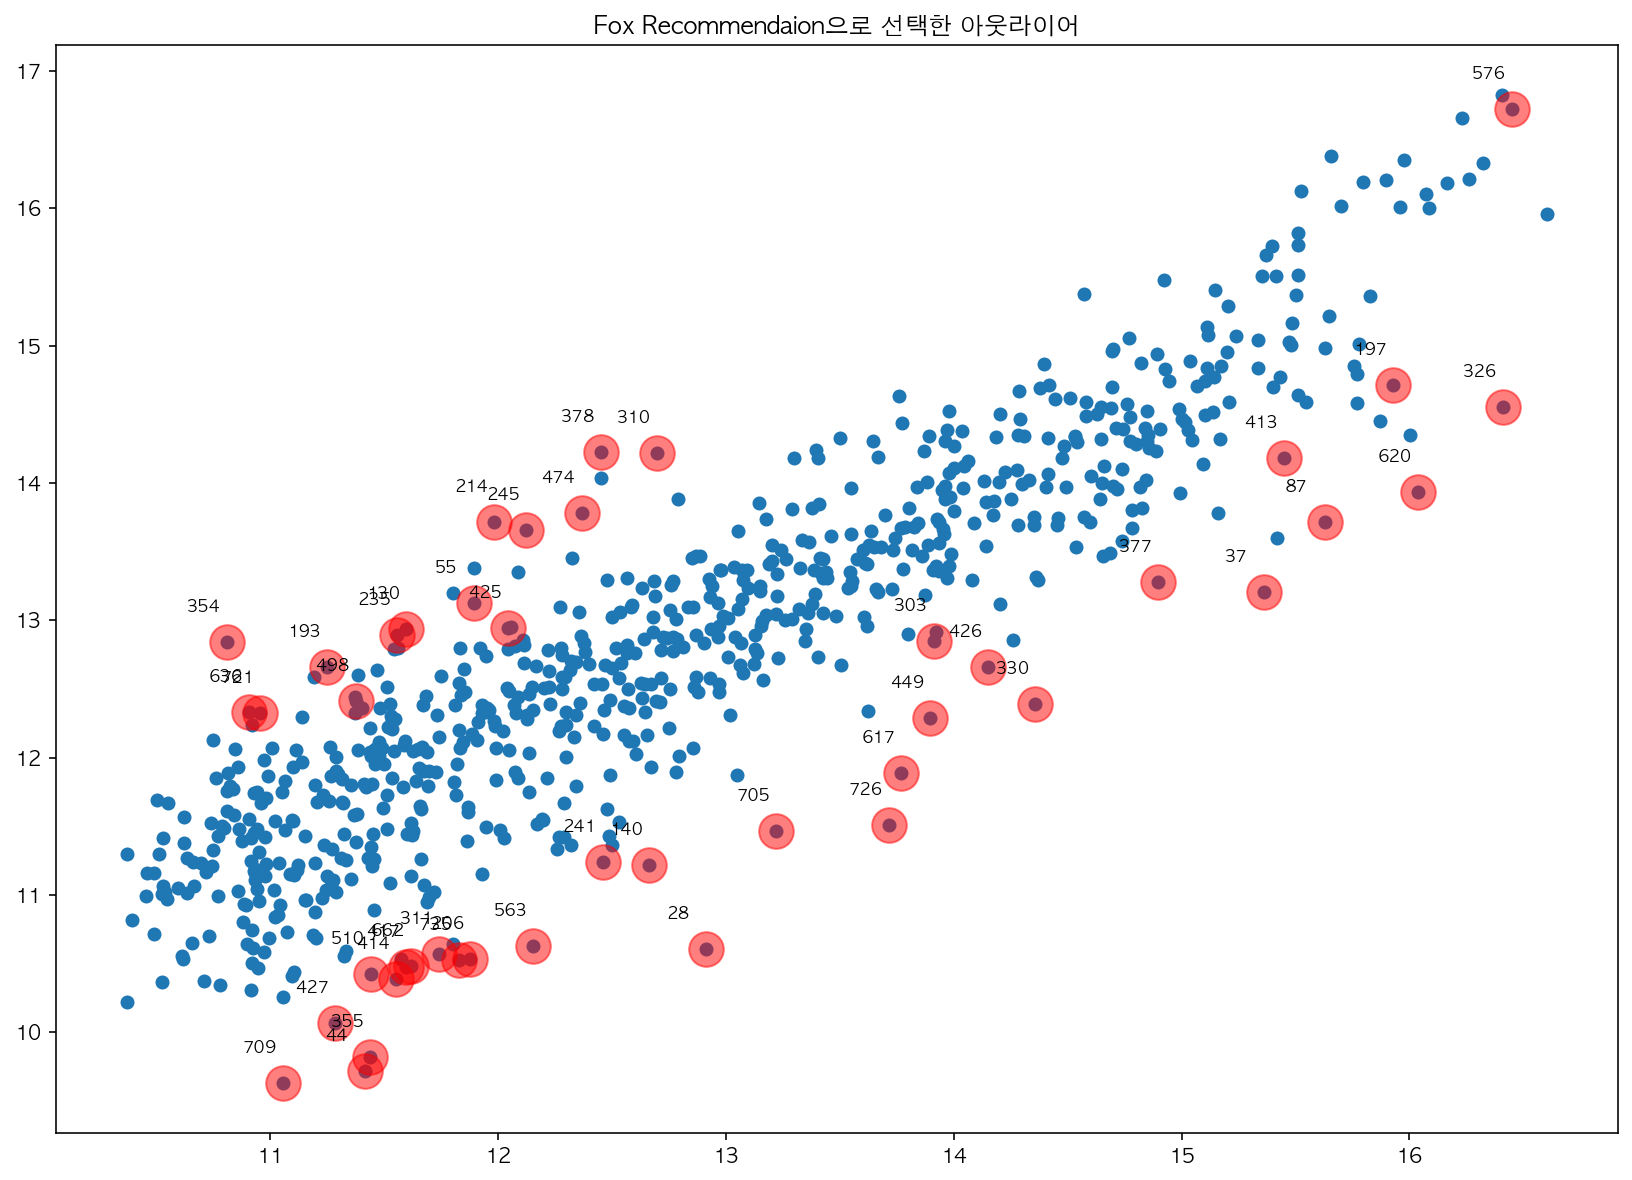

In [76]:
from statsmodels.graphics import utils

plt.figure(figsize=(14, 10))

influence = result7.get_influence()
cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 / (740 - 36 - 1)
idx = np.where(cooks_d2 > fox_cr)[0]

ax = plt.subplot()
plt.scatter(dfy, pred)
plt.scatter(dfy[idx], pred[idx], s=300, c="r", alpha=0.5)
utils.annotate_axes(range(len(idx)), idx,
                    list(zip(dfy[idx], pred[idx])), [(-20, 15)] * len(idx), size="small", ax=ax)
plt.title("Fox Recommendaion으로 선택한 아웃라이어")
plt.show()

In [77]:
print(idx)

[ 28  37  44  55  87 130 140 193 197 206 214 235 241 245 303 310 311 326
 330 354 355 377 378 413 414 417 425 426 427 449 474 498 510 563 576 617
 620 636 662 705 709 721 726 735]


In [78]:
cooks_dict = {}
for index in idx:
    cooks_dict[str(index)] = cooks_d2[index]

In [79]:
cooks_dict = sorted(cooks_dict.items(), key=(lambda x : x[1]), reverse=True)

In [80]:
cooks_arr = cooks_dict[:7]
cooks_arr

[('426', 0.04248506117833746),
 ('354', 0.03877428108555198),
 ('28', 0.033029845448531304),
 ('449', 0.02515432679776791),
 ('140', 0.022383851848427075),
 ('726', 0.02141719306289632),
 ('617', 0.02013130587132252)]

In [81]:
outlier_index = []
for value in cooks_arr:
    print(value[0], df8.iloc[int(value[0])]['title'])
    outlier_index.append(int(value[0]))

426 벤허
354 옥자
28 나의 소녀시대
449 하루
140 번 더 스테이지: 더 무비
726 월요일이 사라졌다
617 님아, 그 강을 건너지 마오


In [82]:
df8 = df8.drop(index=outlier_index)

In [83]:
len(df8)

733

In [84]:
# 16개의 독립변수 사용

feature_names = ['screen**(4/7)', 'expert_rating', 'audience_rating', 'running_times',
                 'actor_power', 'director_power', 'np.log(before_news_0to1)', 'np.log(after_news_0to1)','np.log(rating_audiences_0to1)']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat', 'C(holiday)',
                                                                        'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model8 = sm.OLS.from_formula(
    "log_aud ~" + "+".join(feature_names), data=df8)
result8 = model8.fit()
print(result8.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     96.72
Date:                Thu, 16 Apr 2020   Prob (F-statistic):          2.13e-241
Time:                        19:07:08   Log-Likelihood:                -688.52
No. Observations:                 733   AIC:                             1449.
Df Residuals:                     697   BIC:                             1615.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [85]:
# kfold 8

from sklearn.model_selection import KFold

kfold_dict_learn['8'] = []
kfold_dict['8'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df8)):
    df_train = df8.iloc[idx_train]
    df_test = df8.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news_0to1', 'after_news_0to1', 'rating_audiences_0to1', 'holiday', 'dist_cat',
                                   'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict_learn['8'].append(result.rsquared)
    kfold_dict['8'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['8'])/10)

학습 R2 = 0.83388274, 검증 R2 = 0.77522263
학습 R2 = 0.82645506, 검증 R2 = 0.84588455
학습 R2 = 0.82555286, 검증 R2 = 0.84151863
학습 R2 = 0.83154740, 검증 R2 = 0.79402234
학습 R2 = 0.83035087, 검증 R2 = 0.80619643
학습 R2 = 0.83089301, 검증 R2 = 0.80506353
학습 R2 = 0.82666495, 검증 R2 = 0.84293480
학습 R2 = 0.83073081, 검증 R2 = 0.80380651
학습 R2 = 0.83905039, 검증 R2 = 0.71599751
학습 R2 = 0.82593811, 검증 R2 = 0.85050213


In [86]:
# model8의 테스트 R

pred = result8.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news_0to1', 'after_news_0to1', 'rating_audiences_0to1', 'holiday', 'dist_cat',
                               'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['log_aud'] - pred) ** 2).sum()
tss = ((y_test['log_aud'] - y_test['log_aud'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.803535812823789

In [87]:
test_rsquare_dict['8'] = rsquared

In [88]:
pred = result8.predict(X_test)
print('Mean_Squared_Error = ', mean_squared_error(
    pred, y_test['aud_nationwide']))
print('RMSE = ', mean_squared_error(pred, y_test['aud_nationwide'])**0.5)
RMSE_dict['8'] = mean_squared_error(pred, y_test['aud_nationwide'])**0.5

Mean_Squared_Error =  4822243758168.345
RMSE =  2195960.7824750296


In [89]:
result_rsquare['result8_rsquared'] = result8.rsquared
result_adj_rsquare['result8_adj_rsquared'] = result8.rsquared_adj

# model9
- VIF로 실수형 컬럼 중에 다중공선성 의심되는 피쳐 제거하고 성능의 변화 확인하기

In [90]:
df9 = df8.copy()

In [91]:
# 실수형 피쳐만 다중공선성 VIF로 확인

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
df9_1 = df9.drop(columns=['log_aud', 'aud_nationwide'])

df9_1['screen_sqrt'] = df9_1['screen'].apply(lambda num : num**(4/7))
df9_1['before_news_log'] = df9_1['before_news_0to1'].apply(lambda news : np.log(news))
df9_1['after_news_log'] = df9_1['after_news_0to1'].apply(lambda news : np.log(news))
df9_1['rating_audiences_log'] = df9_1['rating_audiences_0to1'].apply(lambda aud : np.log(aud))

df9_1 = df9_1[['screen_sqrt', 'expert_rating', 'audience_rating', 'running_times',
                 'actor_power', 'director_power', 'before_news_log', 'after_news_log', 'rating_audiences_log']]

vif["VIF Factor"] = [variance_inflation_factor(
    df9_1.values, i) for i in range(df9_1.shape[1])]
vif["features"] = df9_1.columns
vif

,VIF Factor,features
0,28.041115,screen_sqrt
1,11.433091,expert_rating
2,33.554298,audience_rating
3,37.723210,running_times
4,2.117735,actor_power
5,1.289065,director_power
6,26.647527,before_news_log
7,79.835961,after_news_log
8,36.722457,rating_audiences_log


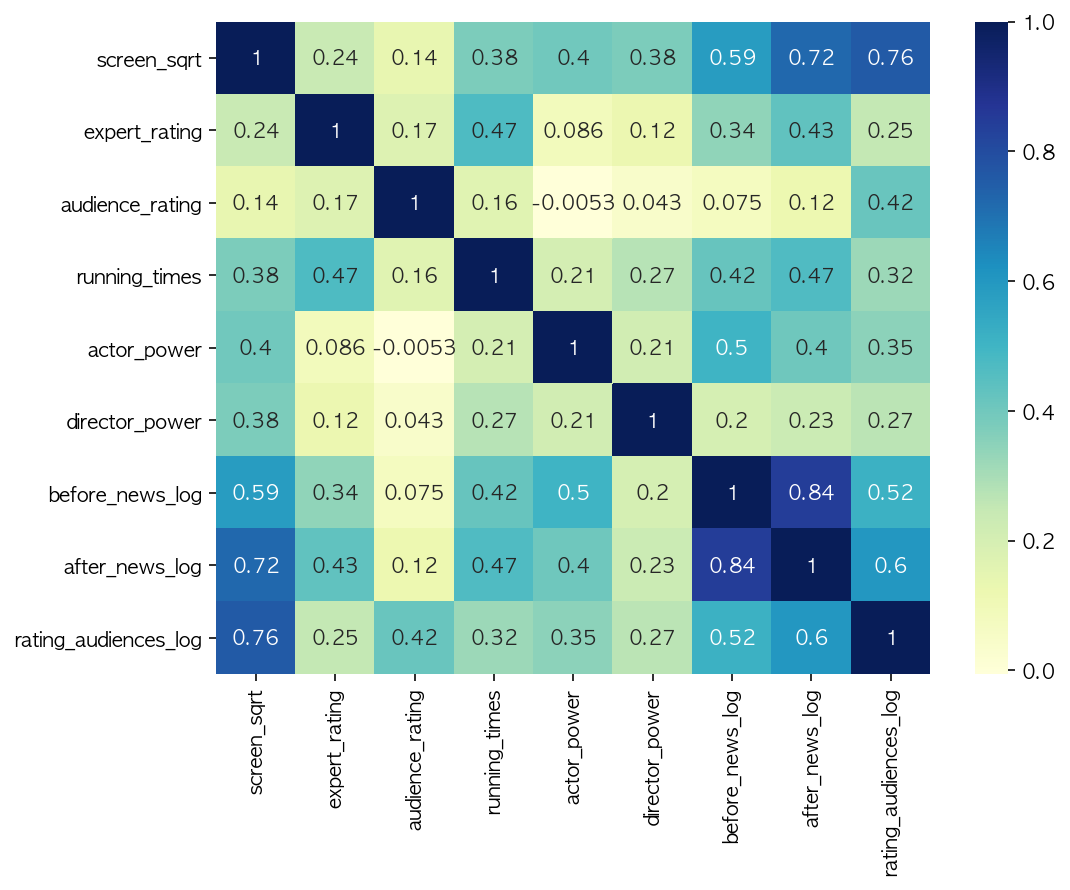

In [92]:
plt.figure(figsize=(8, 6))
sns.heatmap(df9_1.corr(), annot=True, cmap="YlGnBu")

plt.show()

In [97]:
# 15개의 독립변수 사용

feature_names = ['screen**(4/7)', 'expert_rating', 'audience_rating', 'running_times',
                 'actor_power', 'director_power', 'np.log(before_news_0to1)' , 'np.log(rating_audiences_0to1)']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat', 'C(holiday)',
                                                                        'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model9 = sm.OLS.from_formula(
    "log_aud ~" + "+".join(feature_names), data=df9)
result9 = model9.fit()
print(result9.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     98.70
Date:                Thu, 16 Apr 2020   Prob (F-statistic):          3.82e-241
Time:                        19:08:24   Log-Likelihood:                -691.59
No. Observations:                 733   AIC:                             1453.
Df Residuals:                     698   BIC:                             1614.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [98]:
# kfold 9

from sklearn.model_selection import KFold

kfold_dict_learn['9'] = []
kfold_dict['9'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df9)):
    df_train = df9.iloc[idx_train]
    df_test = df9.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'actor_power', 'director_power', 'running_times', 
                                   'before_news_0to1', 'rating_audiences_0to1', 'holiday', 'dist_cat', 'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict_learn['9'].append(result.rsquared)
    kfold_dict['9'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['9'])/10)

학습 R2 = 0.83223387, 검증 R2 = 0.77607120
학습 R2 = 0.82537060, 검증 R2 = 0.84116747
학습 R2 = 0.82393869, 검증 R2 = 0.84148026
학습 R2 = 0.82956421, 검증 R2 = 0.79824784
학습 R2 = 0.82939305, 검증 R2 = 0.80062155
학습 R2 = 0.82967128, 검증 R2 = 0.80160536
학습 R2 = 0.82536912, 검증 R2 = 0.84009080
학습 R2 = 0.82912720, 검증 R2 = 0.80358459
학습 R2 = 0.83764706, 검증 R2 = 0.71434690
학습 R2 = 0.82423972, 검증 R2 = 0.85191633


In [99]:
# model9의 테스트 R

pred = result9.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'actor_power', 'director_power', 'running_times',
                                'before_news_0to1', 'rating_audiences_0to1', 'holiday', 'dist_cat', 'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['log_aud'] - pred) ** 2).sum()
tss = ((y_test['log_aud'] - y_test['log_aud'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.8002135828485589

In [100]:
test_rsquare_dict['9'] = rsquared

In [101]:
pred = result9.predict(X_test)
print('Mean_Squared_Error = ', mean_squared_error(
    pred, y_test['aud_nationwide']))
print('RMSE = ', mean_squared_error(pred, y_test['aud_nationwide'])**0.5)
RMSE_dict['9'] = mean_squared_error(pred, y_test['aud_nationwide'])**0.5

Mean_Squared_Error =  4822243745844.749
RMSE =  2195960.779669061


In [102]:
result_rsquare['result9_rsquared'] = result9.rsquared
result_adj_rsquare['result9_adj_rsquared'] = result9.rsquared_adj

# model10
- ANOVA 테스트로 범주형 변수 선별하고 성능 변화 확인하기
    - 범주형 컬럼 중 anova f-test의 p-value가 가장 높은 세개 먼저 제거
        - holiday, nation, genre, rate

In [104]:
df10 = df9.copy()

In [105]:
# 실수형 피쳐만 다중공선성 VIF로 확인

# from statsmodels.stats.outliers_influence import variance_inflation_factor

# vif = pd.DataFrame()
# df10_1 = df10.drop(columns=['log_aud', 'aud_nationwide'])

# df10_1['screen_sqrt'] = df10_1['screen'].apply(lambda num : num**(4/7))
# df10_1['before_news_log'] = df10_1['before_news_0to1'].apply(lambda news : np.log(news))
# # df10_1['after_news_log'] = df10_1['after_news_0to1'].apply(lambda news : np.log(news))
# df10_1['rating_audiences_log'] = df10_1['rating_audiences_0to1'].apply(lambda aud : np.log(aud))

# df10_1 = df10_1[['screen_sqrt', 'expert_rating', 'audience_rating', 'running_times',
#                  'actor_power', 'director_power', 'before_news_log', 'rating_audiences_log']]

# vif["VIF Factor"] = [variance_inflation_factor(
#     df10_1.values, i) for i in range(df10_1.shape[1])]
# vif["features"] = df10_1.columns
# vif

In [106]:
# plt.figure(figsize=(8, 6))
# sns.heatmap(df10_1.corr(), annot=True, cmap="YlGnBu")

# plt.show()

In [108]:
anova_df = sm.stats.anova_lm(result9, typ=2)
anova_df.sort_values(by=['PR(>F)'], ascending=False)

,sum_sq,df,F,PR(>F)
C(original),0.065503,1.0,0.161423,6.879726e-01
scale(running_times),0.164817,1.0,0.406171,5.241285e-01
nation,2.206640,5.0,1.087596,3.658463e-01
scale(actor_power),0.452680,1.0,1.115573,2.912392e-01
C(holiday),0.555827,1.0,1.369765,2.422517e-01
dist_cat,1.263075,2.0,1.556343,2.116370e-01
genre,7.009334,13.0,1.328739,1.904423e-01
rate,2.806740,3.0,2.305617,7.556368e-02
scale(audience_rating),1.826073,1.0,4.500122,3.424425e-02
scale(expert_rating),1.967209,1.0,4.847933,2.800568e-02


In [109]:
df10 = df10.drop(columns=['holiday', 'nation', 'rate', 'original'])

In [110]:
# ?개의 독립변수 사용

feature_names = ['screen**(4/7)', 'expert_rating', 'audience_rating', 'running_times',
                 'actor_power', 'director_power', 'np.log(before_news_0to1)' , 'np.log(rating_audiences_0to1)']
feature_names = ["scale({})".format(name)
                 for name in feature_names] + ['dist_cat', 'genre', 'C(sequel)']
model10 = sm.OLS.from_formula(
    "log_aud ~" + "+".join(feature_names), data=df10)
result10 = model10.fit()
print(result10.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     138.3
Date:                Thu, 16 Apr 2020   Prob (F-statistic):          2.38e-248
Time:                        19:10:13   Log-Likelihood:                -699.31
No. Observations:                 733   AIC:                             1449.
Df Residuals:                     708   BIC:                             1564.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [111]:
# kfold 10

from sklearn.model_selection import KFold

kfold_dict_learn['10'] = []
kfold_dict['10'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df10)):
    df_train = df10.iloc[idx_train]
    df_test = df10.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'actor_power', 'director_power', 'audience_rating', 'running_times',
                                   'before_news_0to1', 'rating_audiences_0to1', 'dist_cat', 'genre', 'sequel']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict_learn['10'].append(result.rsquared)
    kfold_dict['10'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['10'])/10)

학습 R2 = 0.82763682, 검증 R2 = 0.78168201
학습 R2 = 0.82121103, 검증 R2 = 0.84485021
학습 R2 = 0.81928457, 검증 R2 = 0.84876893
학습 R2 = 0.82609055, 검증 R2 = 0.79635706
학습 R2 = 0.82547045, 검증 R2 = 0.80195383
학습 R2 = 0.82603435, 검증 R2 = 0.79932756
학습 R2 = 0.82132541, 검증 R2 = 0.84044324
학습 R2 = 0.82630846, 검증 R2 = 0.79413184
학습 R2 = 0.83424762, 검증 R2 = 0.71082107
학습 R2 = 0.82006589, 검증 R2 = 0.85451441


In [112]:
# model10의 테스트 R

pred = result10.predict(X_test[['screen', 'expert_rating', 'actor_power', 'director_power', 'audience_rating', 'running_times',
                                   'before_news_0to1', 'rating_audiences_0to1', 'dist_cat', 'genre', 'sequel']])
rss = ((y_test['log_aud'] - pred) ** 2).sum()
tss = ((y_test['log_aud'] - y_test['log_aud'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.8005606168285515

In [113]:
test_rsquare_dict['10'] = rsquared

In [114]:
len(test_rsquare_dict)

10

In [115]:
pred = result10.predict(X_test)
print('Mean_Squared_Error = ', mean_squared_error(
    pred, y_test['aud_nationwide']))
print('RMSE = ', mean_squared_error(pred, y_test['aud_nationwide'])**0.5)
RMSE_dict['10'] = mean_squared_error(pred, y_test['aud_nationwide'])**0.5

Mean_Squared_Error =  4822243688285.789
RMSE =  2195960.766563417


In [116]:
result_rsquare['result10_rsquared'] = result10.rsquared
result_adj_rsquare['result10_adj_rsquared'] = result10.rsquared_adj

# Kfold box-plot : model1 ~ model10

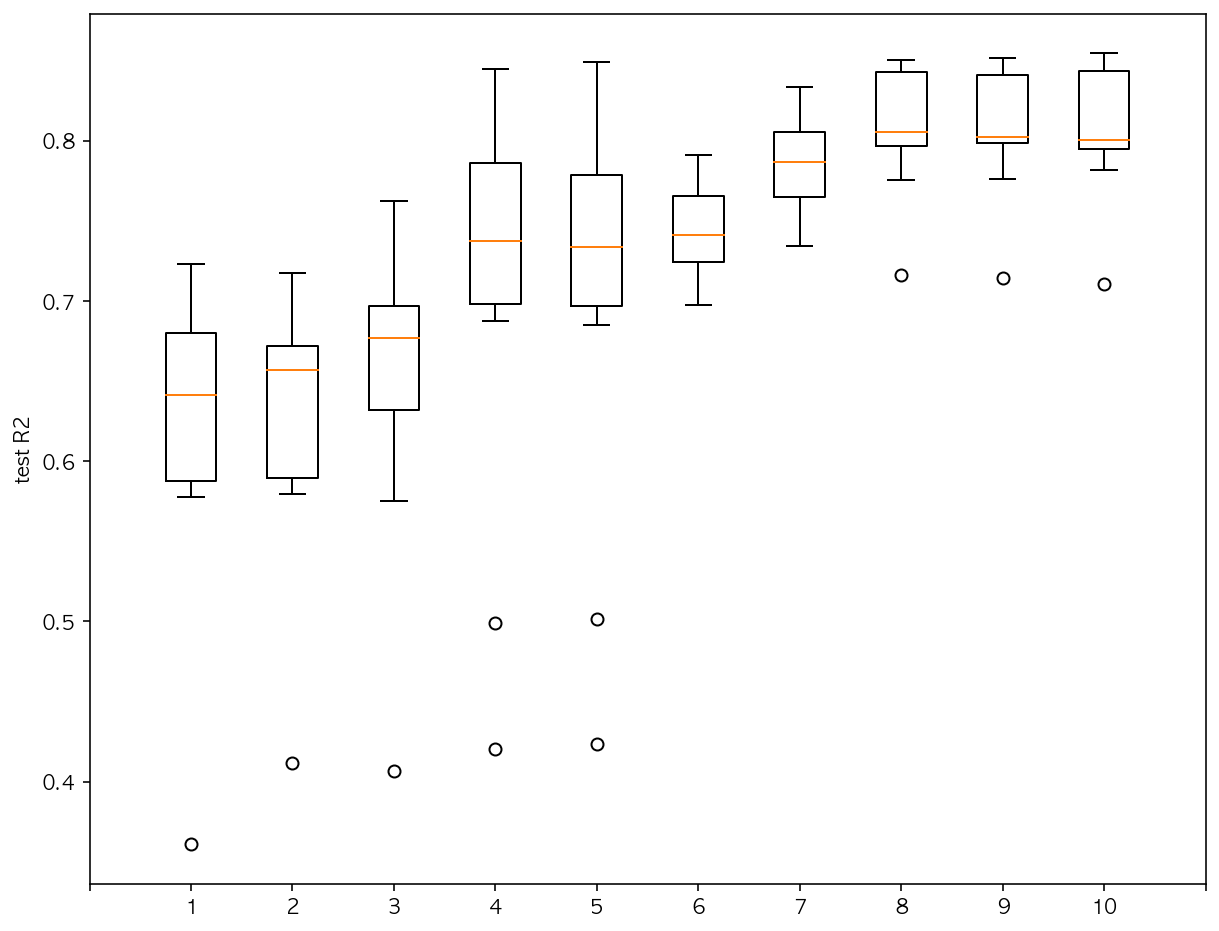

In [117]:
for i in range(1, len(kfold_dict) + 1):
    kfold_df[str(i)] = kfold_dict[str(i)]

plt.figure(figsize=(10, 8))
plt.boxplot((kfold_df['1'], kfold_df['2'], kfold_df['3'], kfold_df['4'],
             kfold_df['5'], kfold_df['6'], kfold_df['7'], kfold_df['8'], kfold_df['9'], kfold_df['10']))
plt.ylabel("test R2")
plt.xticks(np.arange(12), ('', '1', '2', '3',
                           '4', '5', '6', '7', '8', '9', '10'))

plt.show()

In [118]:
len(test_rsquare_dict)

10

In [119]:
model_name_arr = []
for key, value in test_rsquare_dict.items():
    model_name_arr.append('model' + str(key))   
result_df = pd.DataFrame(columns=['model'])
result_df['model'] = model_name_arr

test_rsquare_arr = []
for key, value in test_rsquare_dict.items():
    test_rsquare_arr.append(value)
result_df['test_rsquare'] = test_rsquare_arr    

RMSE_arr = []
for key, value in RMSE_dict.items():
    RMSE_arr.append(value)
result_df['RMSE'] = RMSE_arr

rsquare_arr = []
for key, value in result_rsquare.items():
    rsquare_arr.append(value)
result_df['rsquare'] = rsquare_arr

adj_rsquare_arr = []
for key, value in result_adj_rsquare.items():
    adj_rsquare_arr.append(value)
result_df['adj_rsquare'] = adj_rsquare_arr

In [120]:
result_df.head(2)

,model,test_rsquare,RMSE,rsquare,adj_rsquare
0,model1,0.606384,1.216819e+06,0.652259,0.638055
1,model2,0.624336,1.188748e+06,0.665968,0.651343


# model12 => ridge, lasso, elastic 적용


## Ridge

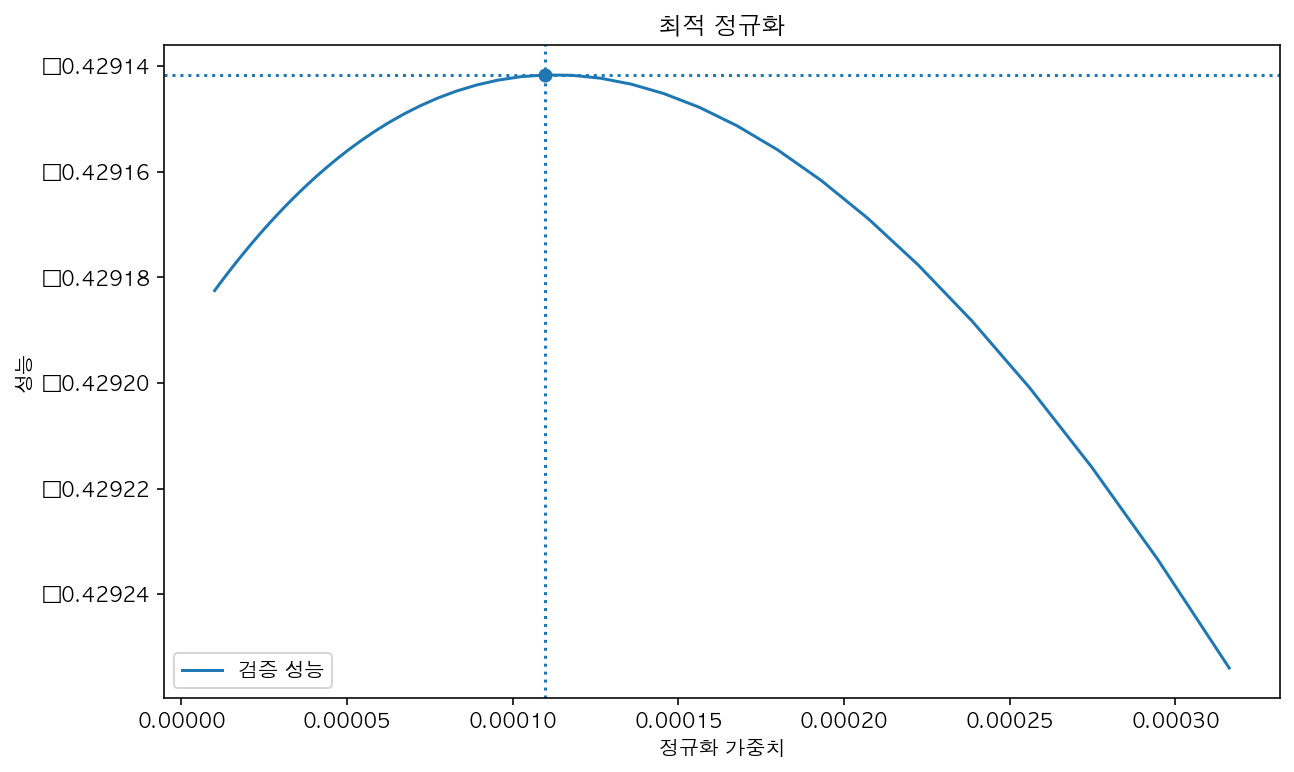

In [122]:
# Ridge 최적 하이퍼모수 선택

# from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import cross_val_score

alphas = np.logspace(-5, -3.5, 50)

train_scores = []
test_scores = []
for alpha in alphas:
    
    test_score_cv = []
    train_score_cv = []
    cv = KFold(5, shuffle=True, random_state=0)
    for i, (idx_train, idx_test) in enumerate(cv.split(df10)):
        df_train = df10.iloc[idx_train]
        df_test = df10.iloc[idx_test]

        model = sm.OLS.from_formula(
            "log_aud ~" + "+".join(feature_names), data=df_train)
        result10_ridge = model.fit_regularized(alpha=alpha, L1_wt=0, refit=False)

        each_train_score = -mean_squared_error(df_train['log_aud'], result10_ridge.predict(df_train[['screen', 'expert_rating', 'actor_power', 'director_power', 'audience_rating', 'running_times',
                                       'before_news_0to1', 'rating_audiences_0to1', 'genre', 'sequel', 'dist_cat']]))
        train_score_cv.append(each_train_score)
        
        each_test_score = -mean_squared_error(df_test['log_aud'], result10_ridge.predict(df_test[['screen', 'expert_rating', 'actor_power', 'director_power', 'audience_rating', 'running_times',
                                       'before_news_0to1', 'rating_audiences_0to1', 'genre', 'sequel', 'dist_cat']]))
        test_score_cv.append(each_test_score)
    
    test_score = np.mean(test_score_cv)
    train_score = np.mean(train_score_cv)
    train_scores.append(train_score)
    test_scores.append(test_score)

optimal_alpha = alphas[np.argmax(test_scores)]
optimal_score = np.max(test_scores)

plt.figure(figsize=(10, 6))
plt.plot(alphas, test_scores, "-", label="검증 성능")
# plt.plot(alphas, train_scores, "--", label="학습 성능")
plt.axhline(optimal_score, linestyle=':')
plt.axvline(optimal_alpha, linestyle=':')
plt.scatter(optimal_alpha, optimal_score)
plt.title("최적 정규화")
plt.ylabel('성능')
plt.xlabel('정규화 가중치')
plt.legend()
plt.show()

In [123]:
optimal_alpha

0.00010985411419875583

In [124]:
# df10.describe()

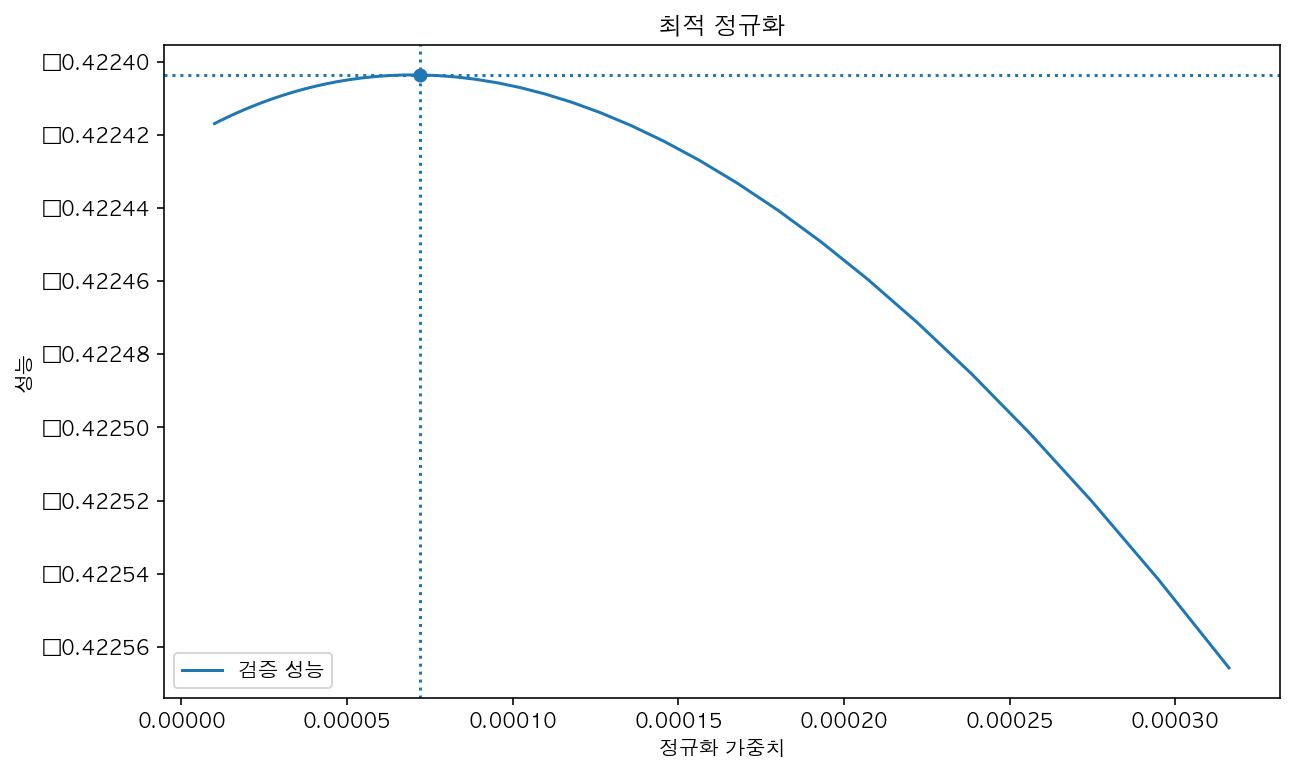

In [125]:
alphas = np.logspace(-5, -3.5, 50)

train_scores = []
test_scores = []
for alpha in alphas:
    
    test_score_cv = []
    train_score_cv = []
    cv = KFold(5, shuffle=True, random_state=2)
    for i, (idx_train, idx_test) in enumerate(cv.split(df10)):
        df_train = df10.iloc[idx_train]
        df_test = df10.iloc[idx_test]

        model = sm.OLS.from_formula(
            "log_aud ~" + "+".join(feature_names), data=df_train)
        result10_ridge = model.fit_regularized(alpha=alpha, L1_wt=0, refit=False)

        each_train_score = -mean_squared_error(df_train['log_aud'], result10_ridge.predict(df_train[['screen', 'expert_rating', 'actor_power', 'director_power', 'audience_rating', 'running_times',
                                       'before_news_0to1', 'rating_audiences_0to1', 'genre', 'sequel', 'dist_cat']]))
        train_score_cv.append(each_train_score)
        
        each_test_score = -mean_squared_error(df_test['log_aud'], result10_ridge.predict(df_test[['screen', 'expert_rating', 'actor_power', 'director_power', 'audience_rating', 'running_times',
                                       'before_news_0to1', 'rating_audiences_0to1', 'genre', 'sequel', 'dist_cat']]))
        test_score_cv.append(each_test_score)
    
    test_score = np.mean(test_score_cv)
    train_score = np.mean(train_score_cv)
    train_scores.append(train_score)
    test_scores.append(test_score)

optimal_alpha = alphas[np.argmax(test_scores)]
optimal_score = np.max(test_scores)

plt.figure(figsize=(10, 6))
plt.plot(alphas, test_scores, "-", label="검증 성능")
# plt.plot(alphas, train_scores, "--", label="학습 성능")
plt.axhline(optimal_score, linestyle=':')
plt.axvline(optimal_alpha, linestyle=':')
plt.scatter(optimal_alpha, optimal_score)
plt.title("최적 정규화")
plt.ylabel('성능')
plt.xlabel('정규화 가중치')
plt.legend()
plt.show()

In [126]:
print("{:f}".format(optimal_alpha))

0.000072


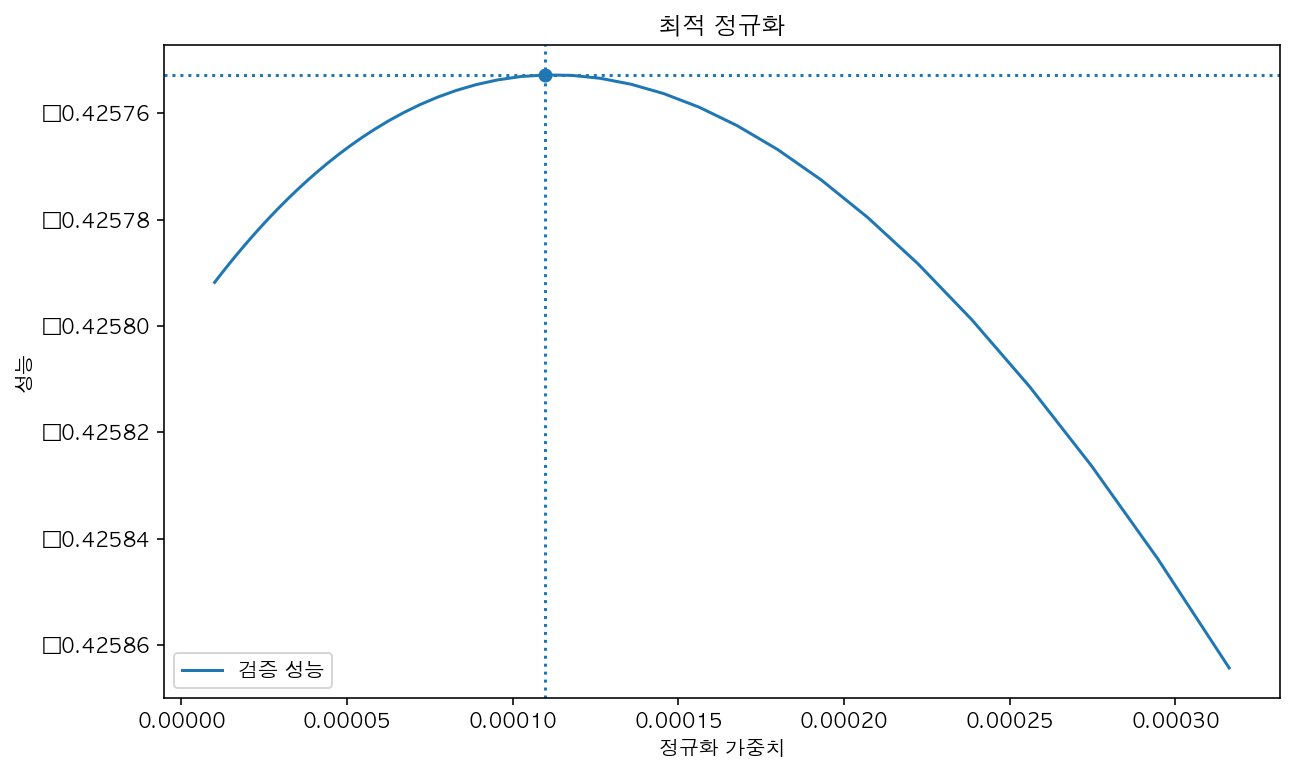

In [127]:
alphas = np.logspace(-5, -3.5, 50)

train_scores = []
test_scores = []
for alpha in alphas:
    
    test_score_cv = []
    train_score_cv = []
    cv = KFold(5, shuffle=True, random_state=3)
    for i, (idx_train, idx_test) in enumerate(cv.split(df10)):
        df_train = df10.iloc[idx_train]
        df_test = df10.iloc[idx_test]

        model = sm.OLS.from_formula(
            "log_aud ~" + "+".join(feature_names), data=df_train)
        result10_ridge = model.fit_regularized(alpha=alpha, L1_wt=0, refit=False)

        each_train_score = -mean_squared_error(df_train['log_aud'], result10_ridge.predict(df_train[['screen', 'expert_rating', 'actor_power', 'director_power', 'audience_rating', 'running_times',
                                       'before_news_0to1', 'rating_audiences_0to1', 'genre', 'sequel', 'dist_cat']]))
        train_score_cv.append(each_train_score)
        
        each_test_score = -mean_squared_error(df_test['log_aud'], result10_ridge.predict(df_test[['screen', 'expert_rating', 'actor_power', 'director_power', 'audience_rating', 'running_times',
                                       'before_news_0to1', 'rating_audiences_0to1', 'genre', 'sequel', 'dist_cat']]))
        test_score_cv.append(each_test_score)
    
    test_score = np.mean(test_score_cv)
    train_score = np.mean(train_score_cv)
    train_scores.append(train_score)
    test_scores.append(test_score)

optimal_alpha = alphas[np.argmax(test_scores)]
optimal_score = np.max(test_scores)

plt.figure(figsize=(10, 6))
plt.plot(alphas, test_scores, "-", label="검증 성능")
# plt.plot(alphas, train_scores, "--", label="학습 성능")
plt.axhline(optimal_score, linestyle=':')
plt.axvline(optimal_alpha, linestyle=':')
plt.scatter(optimal_alpha, optimal_score)
plt.title("최적 정규화")
plt.ylabel('성능')
plt.xlabel('정규화 가중치')
plt.legend()
plt.show()

In [128]:
optimal_alpha

0.00010985411419875583

In [129]:
# kfold 10 - Ridge

from sklearn.model_selection import KFold

kfold_dict_learn['11'] = []
kfold_dict['11'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df10)):
    df_train = df10.iloc[idx_train]
    df_test = df10.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result10_ridge = model.fit_regularized(alpha=optimal_alpha, L1_wt=0, refit=False)

    pred = result10_ridge.predict(df_test[['screen', 'expert_rating', 'actor_power', 'director_power', 'audience_rating', 'running_times',
                                   'before_news_0to1', 'rating_audiences_0to1', 'genre', 'sequel', 'dist_cat']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    
    # train rsquare구하기
    pred = result10_ridge.predict(df_train[['screen', 'expert_rating', 'actor_power', 'director_power', 'audience_rating', 'running_times',
                                   'before_news_0to1', 'rating_audiences_0to1', 'genre', 'sequel', 'dist_cat']])
    rss = ((df_train['log_aud'] - pred) ** 2).sum()
    tss = ((df_train['log_aud'] - df_train['log_aud'].mean()) ** 2).sum()
    train_rsquared = 1 - rss/tss
    
    kfold_dict_learn['11'].append(train_rsquared)
    kfold_dict['11'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(train_rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['11'])/10)

학습 R2 = 0.82762068, 검증 R2 = 0.78188978
학습 R2 = 0.82119534, 검증 R2 = 0.84464731
학습 R2 = 0.81926421, 검증 R2 = 0.84901772
학습 R2 = 0.82607058, 검증 R2 = 0.79619183
학습 R2 = 0.82544705, 검증 R2 = 0.80246640
학습 R2 = 0.82602028, 검증 R2 = 0.79855102
학습 R2 = 0.82130873, 검증 R2 = 0.84062367
학습 R2 = 0.82629106, 검증 R2 = 0.79454765
학습 R2 = 0.83423203, 검증 R2 = 0.71072152
학습 R2 = 0.82004981, 검증 R2 = 0.85443681


In [130]:
# model10 - Ridge의 테스트 R2

result10_ridge = model10.fit_regularized(alpha=optimal_alpha, L1_wt=0, refit=False)
pred = result10_ridge.predict(X_test[['screen', 'expert_rating', 'actor_power', 'director_power', 'audience_rating', 'running_times',
                                   'before_news_0to1', 'rating_audiences_0to1', 'genre', 'sequel', 'dist_cat']])
rss = ((y_test['log_aud'] - pred) ** 2).sum()
tss = ((y_test['log_aud'] - y_test['log_aud'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.8010281837773194

In [131]:
test_rsquare_dict['11'] = rsquared

## Lasso

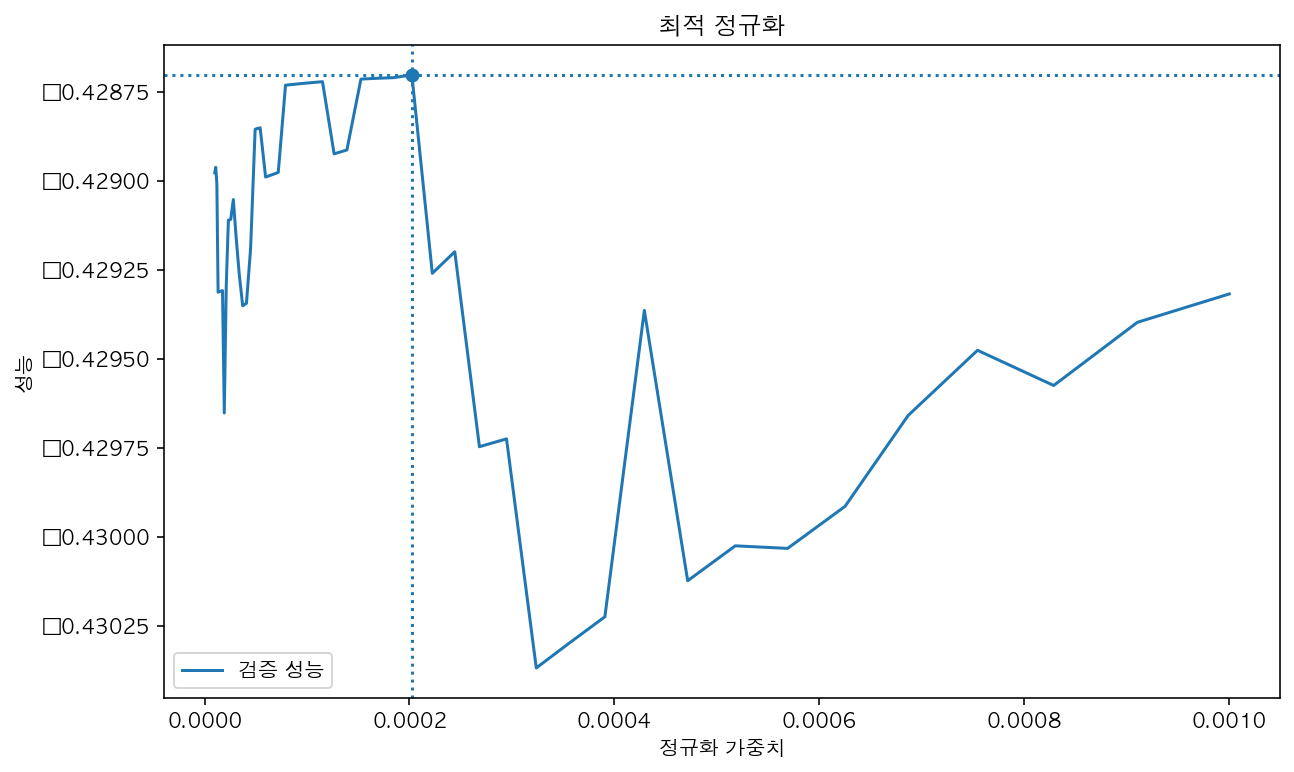

In [132]:
# Lasso 최적 하이퍼모수 선택

# from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import cross_val_score

alphas = np.logspace(-5, -3, 50)

train_scores = []
test_scores = []
for alpha in alphas:
    
    test_score_cv = []
    train_score_cv = []
    cv = KFold(5, shuffle=True, random_state=0)
    for i, (idx_train, idx_test) in enumerate(cv.split(df10)):
        df_train = df10.iloc[idx_train]
        df_test = df10.iloc[idx_test]

        model = sm.OLS.from_formula(
            "log_aud ~" + "+".join(feature_names), data=df_train)
        result10_ridge = model.fit_regularized(alpha=alpha, L1_wt=1, refit=False)

        each_train_score = -mean_squared_error(df_train['log_aud'], result10_ridge.predict(df_train[['screen', 'expert_rating', 'actor_power', 'director_power', 'audience_rating', 'running_times',
                                       'before_news_0to1', 'rating_audiences_0to1', 'genre', 'sequel', 'dist_cat']]))
        train_score_cv.append(each_train_score)
        
        each_test_score = -mean_squared_error(df_test['log_aud'], result10_ridge.predict(df_test[['screen', 'expert_rating', 'actor_power', 'director_power', 'audience_rating', 'running_times',
                                       'before_news_0to1', 'rating_audiences_0to1', 'genre', 'sequel', 'dist_cat']]))
        test_score_cv.append(each_test_score)
    
    test_score = np.mean(test_score_cv)
    train_score = np.mean(train_score_cv)
    train_scores.append(train_score)
    test_scores.append(test_score)

optimal_alpha = alphas[np.argmax(test_scores)]
optimal_score = np.max(test_scores)

plt.figure(figsize=(10, 6))
plt.plot(alphas, test_scores, "-", label="검증 성능")
# plt.plot(alphas, train_scores, "--", label="학습 성능")
plt.axhline(optimal_score, linestyle=':')
plt.axvline(optimal_alpha, linestyle=':')
plt.scatter(optimal_alpha, optimal_score)
plt.title("최적 정규화")
plt.ylabel('성능')
plt.xlabel('정규화 가중치')
plt.legend()
plt.show()

In [133]:
optimal_alpha

0.00020235896477251554

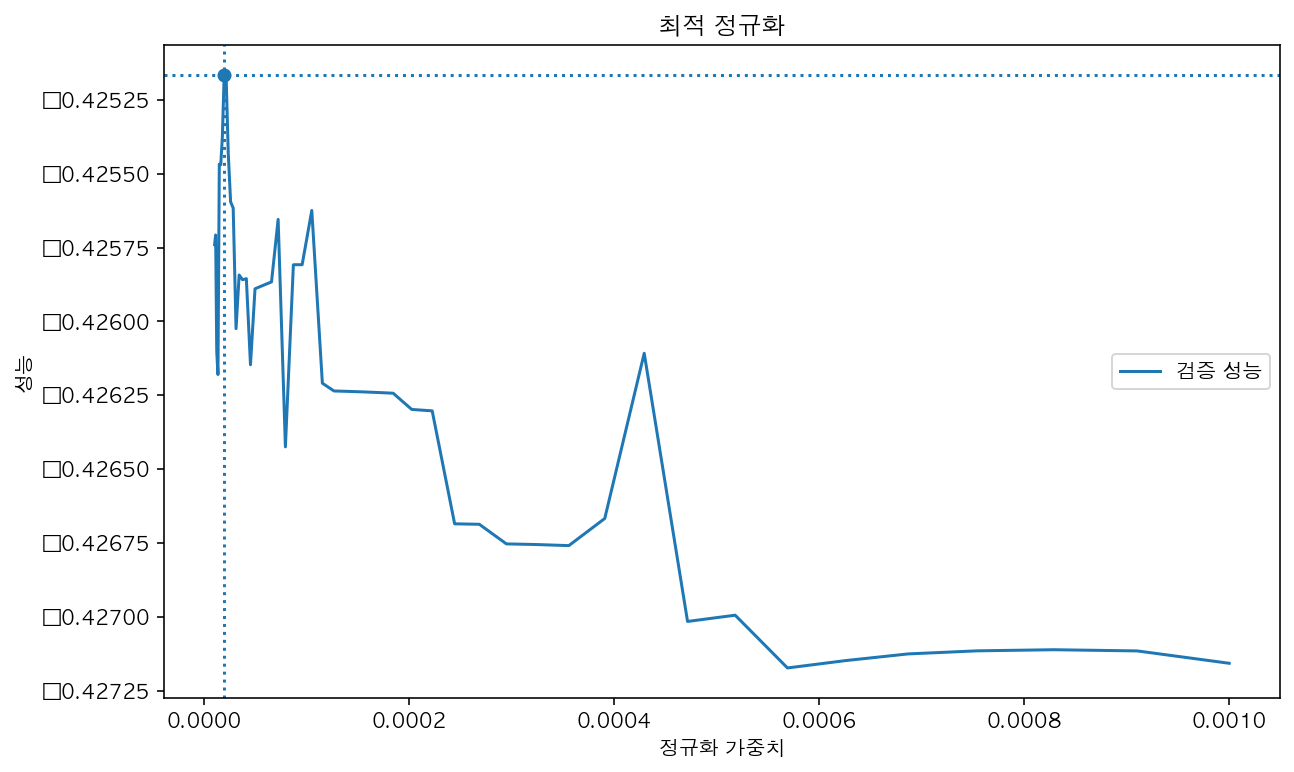

In [134]:
# Lasso 최적 하이퍼모수 선택

# from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import cross_val_score

alphas = np.logspace(-5, -3, 50)

train_scores = []
test_scores = []
for alpha in alphas:
    
    test_score_cv = []
    train_score_cv = []
    cv = KFold(5, shuffle=True, random_state=1)
    for i, (idx_train, idx_test) in enumerate(cv.split(df10)):
        df_train = df10.iloc[idx_train]
        df_test = df10.iloc[idx_test]

        model = sm.OLS.from_formula(
            "log_aud ~" + "+".join(feature_names), data=df_train)
        result10_ridge = model.fit_regularized(alpha=alpha, L1_wt=1, refit=False)

        each_train_score = -mean_squared_error(df_train['log_aud'], result10_ridge.predict(df_train[['screen', 'expert_rating', 'actor_power', 'director_power', 'audience_rating', 'running_times',
                                       'before_news_0to1', 'rating_audiences_0to1', 'genre', 'sequel', 'dist_cat']]))
        train_score_cv.append(each_train_score)
        
        each_test_score = -mean_squared_error(df_test['log_aud'], result10_ridge.predict(df_test[['screen', 'expert_rating', 'actor_power', 'director_power', 'audience_rating', 'running_times',
                                       'before_news_0to1', 'rating_audiences_0to1', 'genre', 'sequel', 'dist_cat']]))
        test_score_cv.append(each_test_score)
    
    test_score = np.mean(test_score_cv)
    train_score = np.mean(train_score_cv)
    train_scores.append(train_score)
    test_scores.append(test_score)

optimal_alpha = alphas[np.argmax(test_scores)]
optimal_score = np.max(test_scores)

plt.figure(figsize=(10, 6))
plt.plot(alphas, test_scores, "-", label="검증 성능")
# plt.plot(alphas, train_scores, "--", label="학습 성능")
plt.axhline(optimal_score, linestyle=':')
plt.axvline(optimal_alpha, linestyle=':')
plt.scatter(optimal_alpha, optimal_score)
plt.title("최적 정규화")
plt.ylabel('성능')
plt.xlabel('정규화 가중치')
plt.legend()
plt.show()

In [136]:
print("{:f}".format(optimal_alpha))

0.000019


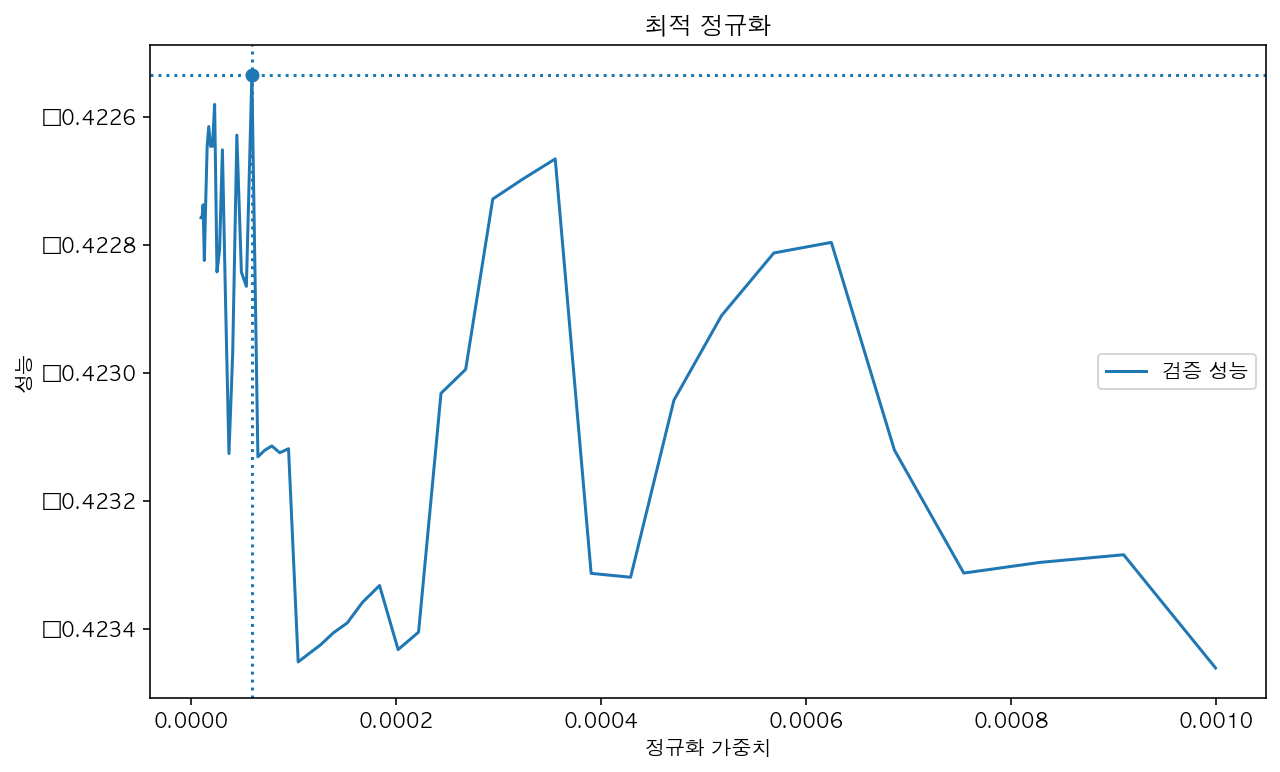

In [137]:
# Lasso 최적 하이퍼모수 선택

# from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import cross_val_score

alphas = np.logspace(-5, -3, 50)

train_scores = []
test_scores = []
for alpha in alphas:
    
    test_score_cv = []
    train_score_cv = []
    cv = KFold(5, shuffle=True, random_state=2)
    for i, (idx_train, idx_test) in enumerate(cv.split(df10)):
        df_train = df10.iloc[idx_train]
        df_test = df10.iloc[idx_test]

        model = sm.OLS.from_formula(
            "log_aud ~" + "+".join(feature_names), data=df_train)
        result10_ridge = model.fit_regularized(alpha=alpha, L1_wt=1, refit=False)

        each_train_score = -mean_squared_error(df_train['log_aud'], result10_ridge.predict(df_train[['screen', 'expert_rating', 'actor_power', 'director_power', 'audience_rating', 'running_times',
                                       'before_news_0to1', 'rating_audiences_0to1', 'genre', 'sequel', 'dist_cat']]))
        train_score_cv.append(each_train_score)
        
        each_test_score = -mean_squared_error(df_test['log_aud'], result10_ridge.predict(df_test[['screen', 'expert_rating', 'actor_power', 'director_power', 'audience_rating', 'running_times',
                                       'before_news_0to1', 'rating_audiences_0to1', 'genre', 'sequel', 'dist_cat']]))
        test_score_cv.append(each_test_score)
    
    test_score = np.mean(test_score_cv)
    train_score = np.mean(train_score_cv)
    train_scores.append(train_score)
    test_scores.append(test_score)

optimal_alpha = alphas[np.argmax(test_scores)]
optimal_score = np.max(test_scores)

plt.figure(figsize=(10, 6))
plt.plot(alphas, test_scores, "-", label="검증 성능")
# plt.plot(alphas, train_scores, "--", label="학습 성능")
plt.axhline(optimal_score, linestyle=':')
plt.axvline(optimal_alpha, linestyle=':')
plt.scatter(optimal_alpha, optimal_score)
plt.title("최적 정규화")
plt.ylabel('성능')
plt.xlabel('정규화 가중치')
plt.legend()
plt.show()

In [138]:
print("{:f}".format(optimal_alpha))

0.000060


In [139]:
# kfold 10 - Lasso

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

kfold_dict_learn['12'] = []
kfold_dict['12'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df10)):
    df_train = df10.iloc[idx_train]
    df_test = df10.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result10_lasso = model.fit_regularized(alpha=optimal_alpha, L1_wt=1, refit=False)

    pred = result10_lasso.predict(df_test[['screen', 'expert_rating', 'actor_power', 'director_power', 'audience_rating', 'running_times',
                                   'before_news_0to1', 'rating_audiences_0to1', 'genre', 'sequel', 'dist_cat']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    # train rsquare구하기
    pred = result10_lasso.predict(df_train[['screen', 'expert_rating', 'actor_power', 'director_power', 'audience_rating', 'running_times',
                                   'before_news_0to1', 'rating_audiences_0to1', 'genre', 'sequel', 'dist_cat']])
    rss = ((df_train['log_aud'] - pred) ** 2).sum()
    tss = ((df_train['log_aud'] - df_train['log_aud'].mean()) ** 2).sum()
    train_rsquared = 1 - rss/tss
    
    kfold_dict_learn['12'].append(train_rsquared)
    kfold_dict['12'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(train_rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['12'])/10)

학습 R2 = 0.82730465, 검증 R2 = 0.78164085
학습 R2 = 0.82105017, 검증 R2 = 0.84526586
학습 R2 = 0.81909208, 검증 R2 = 0.84742418
학습 R2 = 0.82586158, 검증 R2 = 0.79501411
학습 R2 = 0.82530833, 검증 R2 = 0.80005776
학습 R2 = 0.82538324, 검증 R2 = 0.80241274
학습 R2 = 0.82108642, 검증 R2 = 0.83956452
학습 R2 = 0.82588569, 검증 R2 = 0.79459493
학습 R2 = 0.83395859, 검증 R2 = 0.71009130
학습 R2 = 0.81860856, 검증 R2 = 0.85588031


In [140]:
# model12 - Lasso의 테스트 R2

result10_lasso = model.fit_regularized(alpha=optimal_alpha, L1_wt=1, refit=False)
pred = result10_lasso.predict(X_test[['screen', 'expert_rating', 'actor_power', 'director_power', 'audience_rating', 'running_times',
                                   'before_news_0to1', 'rating_audiences_0to1', 'genre', 'sequel', 'dist_cat']])
rss = ((y_test['log_aud'] - pred) ** 2).sum()
tss = ((y_test['log_aud'] - y_test['log_aud'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.7945548824272329

In [141]:
test_rsquare_dict['12'] = rsquared

# Kfold box-plot : Ridge, Lasso 포함
- Ridge와 Lasso를 적용시켰을때 성능개선에 거의 영향이 없었기때문에 Elastic은 pass

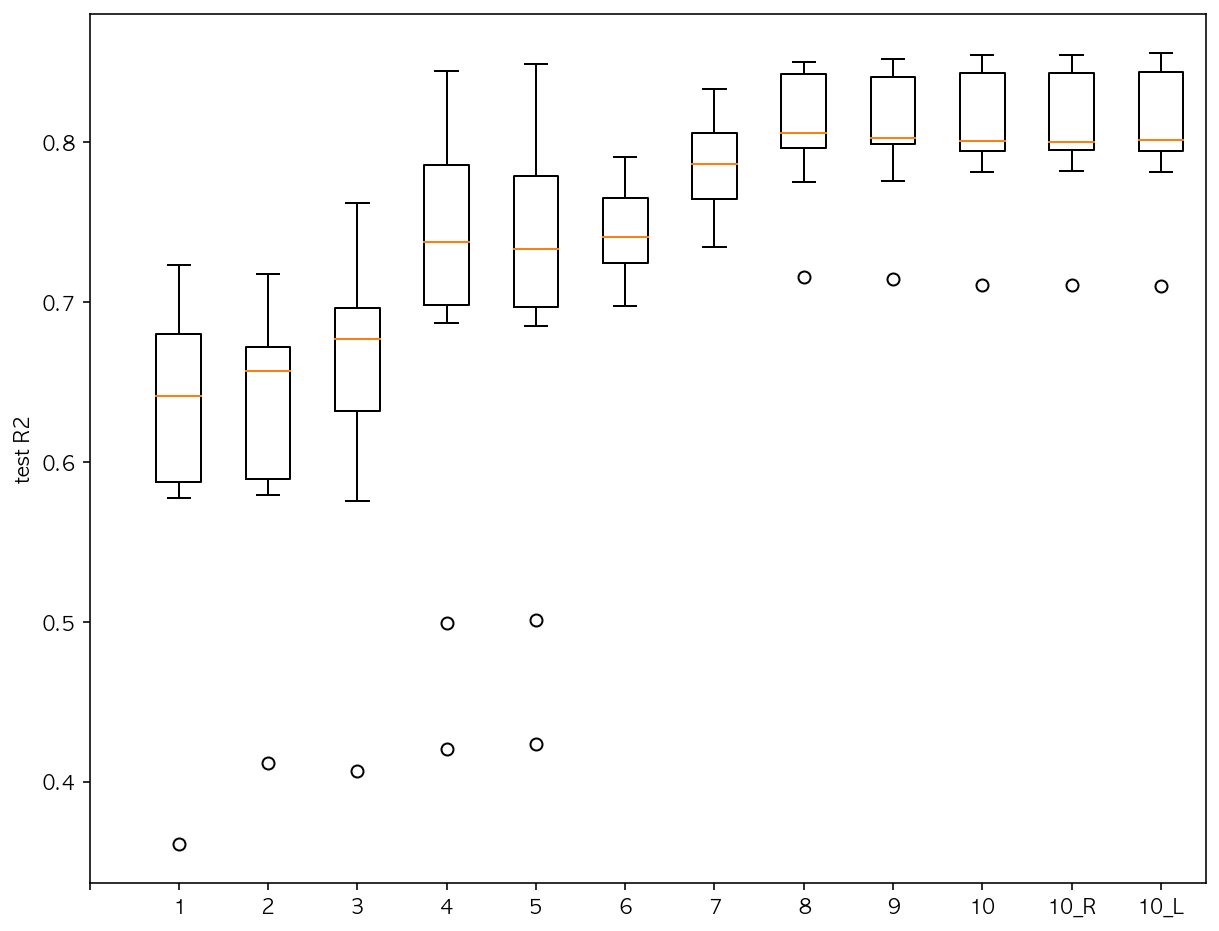

In [142]:
for i in range(1, len(kfold_dict) + 1):
    kfold_df[str(i)] = kfold_dict[str(i)]

plt.figure(figsize=(10, 8))
plt.boxplot((kfold_df['1'], kfold_df['2'], kfold_df['3'], kfold_df['4'], kfold_df['5'], kfold_df['6'], kfold_df['7'],
             kfold_df['8'], kfold_df['9'], kfold_df['10'], kfold_df['11'], kfold_df['12']))
plt.ylabel("test R2")
plt.xticks(np.arange(13), ('', '1', '2', '3', '4', '5', '6',
                           '7', '8', '9', '10', '10_R', '10_L'))

plt.show()

In [143]:
test_rsquare_dict

{'1': 0.6063840307534749,
 '2': 0.6243355959961607,
 '3': 0.6445087799148355,
 '4': 0.7048007034475638,
 '5': 0.6990985325678982,
 '6': 0.7439545187829599,
 '7': 0.793510820664285,
 '8': 0.803535812823789,
 '9': 0.8002135828485589,
 '10': 0.8005606168285515,
 '11': 0.8010281837773194,
 '12': 0.7945548824272329}

In [144]:
model_name_arr = []
for key, value in test_rsquare_dict.items():
    model_name_arr.append('model' + str(key))   
result_df = pd.DataFrame(columns=['model'])
result_df['model'] = model_name_arr

test_rsquare_arr = []
for key, value in test_rsquare_dict.items():
    test_rsquare_arr.append(value)
result_df['test_rsquare'] = test_rsquare_arr  

In [160]:
result_df['model'][10] = 'Ridge'
result_df['model'][11] = 'Lasso'

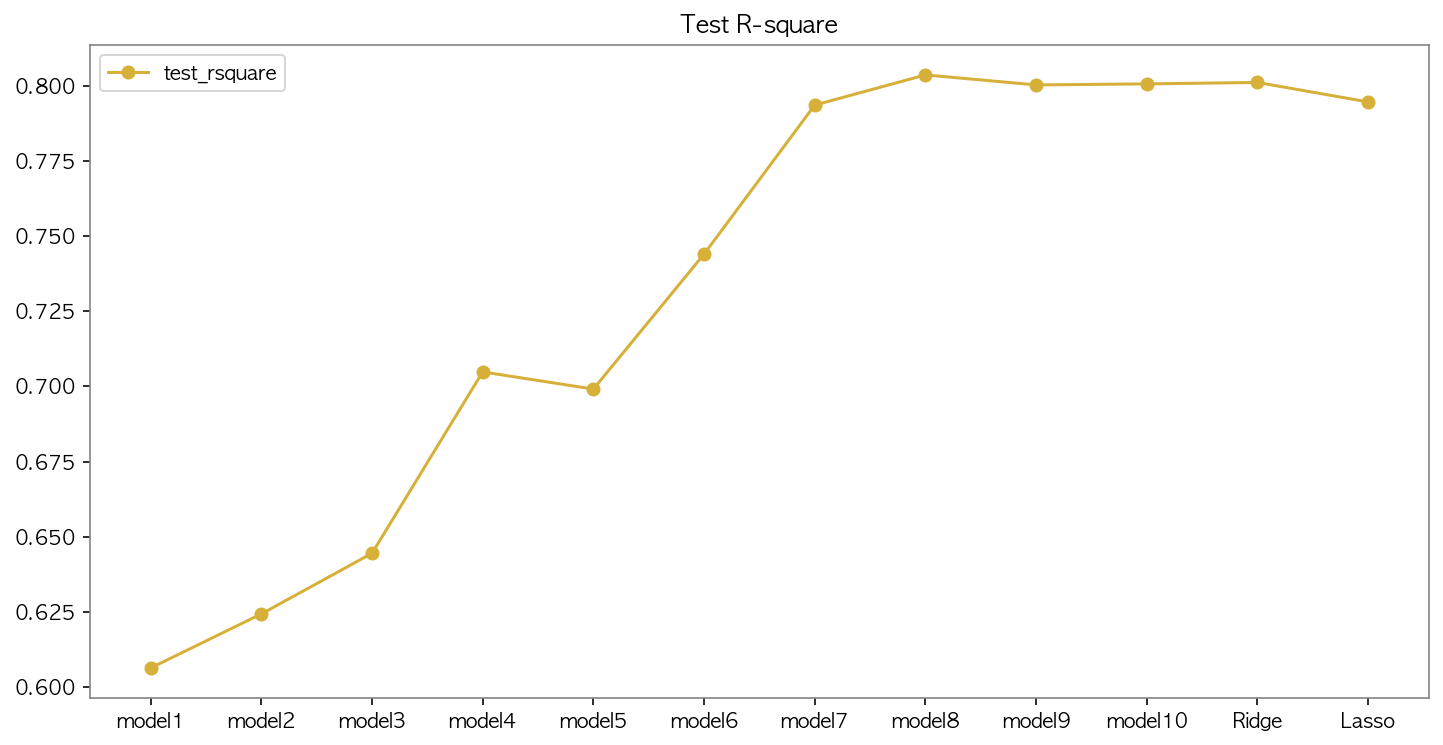

In [164]:
# model10에 Ridge적용 & model10에 Lasso적용한 test-Rsquare

plt.figure(figsize=(12, 6))
ax = plt.axes()
ax.set_facecolor("white")
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
# plt.grid(color='black', linestyle='-', linewidth=0.5)
ax.plot(result_df['model'], result_df['test_rsquare'], "go-" ,color='#D6B038', label='test_rsquare')
plt.title("Test R-square")
plt.legend()
plt.show()

In [2405]:
# kfold 10 - ElasticNet

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

kfold_dict_learn['13'] = []
kfold_dict['13'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df10)):
    df_train = df10.iloc[idx_train]
    df_test = df10.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result10_elasticnet = model.fit_regularized(alpha=optimal_alpha, L1_wt=0.5, refit=False)

    pred = result10_elasticnet.predict(df_test[['screen', 'expert_rating', 'actor_power', 'director_power', 'audience_rating', 'running_times',
                                   'before_news_0to1', 'rating_audiences_0to1', 'genre', 'sequel', 'dist_cat']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    # train rsquare구하기
    pred = result10_elasticnet.predict(df_train[['screen', 'expert_rating', 'actor_power', 'director_power', 'audience_rating', 'running_times',
                                   'before_news_0to1', 'rating_audiences_0to1', 'genre', 'sequel', 'dist_cat']])
    rss = ((df_train['log_aud'] - pred) ** 2).sum()
    tss = ((df_train['log_aud'] - df_train['log_aud'].mean()) ** 2).sum()
    train_rsquared = 1 - rss/tss
    
    kfold_dict_learn['13'].append(train_rsquared)
    kfold_dict['13'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(train_rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['13'])/10)

학습 R2 = 0.82534003, 검증 R2 = 0.78631602
학습 R2 = 0.81971885, 검증 R2 = 0.84805111
학습 R2 = 0.81738789, 검증 R2 = 0.84062634
학습 R2 = 0.82381623, 검증 R2 = 0.79093111
학습 R2 = 0.82451276, 검증 R2 = 0.79905201
학습 R2 = 0.82337066, 검증 R2 = 0.79517603
학습 R2 = 0.81864254, 검증 R2 = 0.83742197
학습 R2 = 0.82496612, 검증 R2 = 0.80108763
학습 R2 = 0.83216189, 검증 R2 = 0.70812285
학습 R2 = 0.81764781, 검증 R2 = 0.85593055


In [2406]:
# model12 - Lasso의 테스트 R2

result10_elasticnet = model.fit_regularized(alpha=optimal_alpha, L1_wt=0.5, refit=False)
pred = result10_elasticnet.predict(X_test[['screen', 'expert_rating', 'actor_power', 'director_power', 'audience_rating', 'running_times',
                                   'before_news_0to1', 'rating_audiences_0to1', 'genre', 'sequel', 'dist_cat']])
rss = ((y_test['log_aud'] - pred) ** 2).sum()
tss = ((y_test['log_aud'] - y_test['log_aud'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.7946579961942952

In [2407]:
test_rsquare_dict['13'] = rsquared

In [2527]:
for key, value in test_rsquare_dict.items():
    model_name_arr.append('model' + str(key))   
result_df_reg = pd.DataFrame(columns=['model'])
result_df_reg['model'] = model_name_arr

test_rsquare_reg_arr = []
for key, value in test_rsquare_dict.items():
    test_rsquare_reg_arr.append(value)
result_df_reg['test_rsquare'] = test_rsquare_reg_arr 